# 🧠 Urdu Conversational Chatbot (Encoder–Decoder Transformer) — From Scratch  

**Objective:**  
Build and train a **complete Urdu conversational chatbot** using the **Transformer Encoder–Decoder architecture** implemented **entirely from scratch in PyTorch**, without using any pre-trained models.  
The chatbot learns to generate **context-aware Urdu replies** by automatically constructing `(source → target)` pairs from conversational transcripts.

---

**What’s inside**  
- 🔤 **SentencePiece (BPE)** tokenizer for subword-level Urdu tokenization  
- ⚙️ **Data pipeline:** loading, normalization, and automated conversational pair creation  
- 🧩 **Transformer model components:**  
  - **Encoder** – captures contextual meaning from input sentences  
  - **Decoder** – generates Urdu responses step-by-step  
  - **Multi-Head Attention**, **Positional Encoding**, and **Feed-Forward layers**  
- 🧮 **Training setup:**  
  - Teacher forcing with **padding & causal masks**  
  - **Cross-Entropy Loss** with Label Smoothing  
  - Evaluation using **BLEU**, **ROUGE-L**, and **chrF** metrics  
- 💬 **Interactive Gradio chatbot** for real-time Urdu dialogue generation  
- 🧠 **Fully explainable pipeline** — no hidden pretrained components

---

**Workflow Overview**  
1. **Data Loading & Cleaning:** Import Urdu dataset (TSV/CSV/TXT), normalize Alef/Ye, and remove diacritics.  
2. **Pair Construction:** Form `(src → dst)` pairs using previous-line logic.  
3. **Subword Tokenization:** Train SentencePiece BPE tokenizer to convert words → token IDs.  
4. **Transformer Model:** Convert token IDs to embeddings, add positional encodings, and train encoder–decoder network.  
5. **Training Loop:** Use teacher forcing with masks, optimize with Adam and gradient clipping.  
6. **Evaluation:** Compute BLEU, chrF, ROUGE-L; visualize generated responses.  
7. **Deployment:** Integrate Gradio UI for end-user Urdu chat experience.

---

**Expected Output**  
-  A trained **Urdu chatbot** capable of generating contextual, meaningful replies.  
- nsight into how the **Transformer encoder–decoder** handles sequence-to-sequence learning.  
- 🔁 A reusable modular notebook for chatbot projects in any low-resource language.

---


#  Cell 1 — Install Dependencies  

**Purpose:**  
Install all required libraries for tokenization, evaluation, and interface deployment.  
These include:  
- `sentencepiece` → subword tokenization (BPE)  
- `sacrebleu` & `rouge-score` → text generation evaluation  
- `gradio` → chatbot web interface  


In [2]:
!pip -q install sentencepiece sacrebleu rouge-score evaluate gradio==4.44.0


#  Cell 2 — Import Libraries, Set Random Seed, and Detect Device  

**Purpose:**  
Import essential Python, PyTorch, and NLP modules,  
set random seeds for reproducibility,  
and detect whether GPU (CUDA) is available.  
This ensures consistent results during multiple runs.  


In [3]:
import os, re, io, glob, zipfile, math, random, json
from pathlib import Path
import numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import sentencepiece as spm
from sklearn.model_selection import train_test_split
import sacrebleu
from rouge_score import rouge_scorer
import gradio as gr

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)


Device: cuda


#  Cell 3 — Upload & Extract Urdu Dataset  

**Purpose:**  
Unzip the provided Urdu dataset (either `archive.zip` or `archeive.zip`) into `/content/data`.  
This cell makes the data accessible for cleaning and preprocessing later.  

**Notes:**  
- Accepts `.zip` files uploaded to Colab.  
- Prints all extracted files to verify dataset structure.  


In [4]:
zip_candidates = ["/content/final_main_dataset.tsv.zip", "/content/archeive.zip"]
zip_path = next((p for p in zip_candidates if os.path.exists(p)), None)
if zip_path is None:
    raise FileNotFoundError("Upload your dataset zip to /content as 'final_main_dataset.tsv.zip' or 'archeive.zip'.")

extract_dir = "/content/data"
Path(extract_dir).mkdir(parents=True, exist_ok=True)
with zipfile.ZipFile(zip_path, "r") as z:
    z.extractall(extract_dir)

print("Extracted files:")
for f in glob.glob(extract_dir + "/**/*", recursive=True):
    if os.path.isfile(f): print("-", f)


Extracted files:
- /content/data/final_main_dataset.tsv


#  Cell 4 — Load Dataset (TSV / CSV / TXT)  

**Purpose:**  
Automatically detect and load dataset format:  
- `.tsv` → tab-separated  
- `.csv` → comma-separated  
- `.txt` → one sentence per line  

**Outcome:**  
A pandas DataFrame containing Urdu sentences ready for text cleaning.  


In [5]:
import pandas as pd

tsv_files = glob.glob(os.path.join(extract_dir, "**/*.tsv"), recursive=True)
csv_files = glob.glob(os.path.join(extract_dir, "**/*.csv"), recursive=True)
txt_files = glob.glob(os.path.join(extract_dir, "**/*.txt"), recursive=True)

data_file = None
if tsv_files:   data_file = tsv_files[0]
elif csv_files: data_file = csv_files[0]
elif txt_files: data_file = txt_files[0]
else: raise FileNotFoundError("No .tsv/.csv/.txt found inside the zip.")

print("Using:", data_file)

if data_file.endswith(".tsv"):
    df = pd.read_csv(data_file, sep="\t", encoding="utf-8", engine="python")
elif data_file.endswith(".csv"):
    df = pd.read_csv(data_file, encoding="utf-8")
else:
    lines = [l.strip() for l in open(data_file, encoding="utf-8", errors="ignore").read().splitlines()]
    df = pd.DataFrame({"sentence": lines})

print(df.head())
print("Rows:", len(df), "Cols:", df.columns.tolist())


Using: /content/data/final_main_dataset.tsv
                                           client_id  \
0  e53f84d151d6cc6d45a57decde08a99efe47d7751a4ca6...   
1  e53f84d151d6cc6d45a57decde08a99efe47d7751a4ca6...   
2  e53f84d151d6cc6d45a57decde08a99efe47d7751a4ca6...   
3  e53f84d151d6cc6d45a57decde08a99efe47d7751a4ca6...   
4  e53f84d151d6cc6d45a57decde08a99efe47d7751a4ca6...   

                           path  \
0  common_voice_ur_31771683.mp3   
1  common_voice_ur_31771684.mp3   
2  common_voice_ur_31771685.mp3   
3  common_voice_ur_31771730.mp3   
4  common_voice_ur_31771732.mp3   

                                            sentence  up_votes  down_votes  \
0                 کبھی کبھار ہی خیالی پلاو بناتا ہوں         2           0   
1                  اور پھر ممکن ہے کہ پاکستان بھی ہو         2           1   
2                      یہ فیصلہ بھی گزشتہ دو سال میں         2           0   
3                     ان کے بلے بازوں کے سامنے ہو گا         3           0   
4  آبی جانور میں ب

#  Cell 5 — Clean & Normalize Urdu Text  

**Purpose:**  
Standardize Urdu writing for consistent tokenization.  
Removes diacritics, unifies Alef (ا) and Yeh (ی) variants,  
and converts punctuation to common forms (، → , , ؟ → ?).  

**Why:**  
Normalization reduces noise and improves vocabulary quality.  


In [6]:
# ===========================
# Urdu Text Normalization (Pro)
# ===========================
# Goals:
# - Unicode normalize (NFKC) + strip zero-widths/tatweel
# - Remove diacritics/Quranic marks safely
# - Unify common Arabic→Urdu letter variants
# - Normalize punctuation (، ؛ ۔ ؟) → ASCII where useful
# - Optional: convert Eastern digits → Western (config)
# - Preserve Urdu-specific contrasts (e.g., "ے" NOT collapsed to "ی")

import re, unicodedata

# ---------- Config ----------
NORMALIZE_PUNCT = True          # map Urdu punct to ASCII , ; . ?
CONVERT_EASTERN_DIGITS = True   # Urdu "۰۱۲۳۴۵۶۷۸۹" → "0123456789"
KEEP_ONLY_URDU_BLOCK = False    # if True: drop Latin/emoji/etc. (useful for very noisy corpora)


ZW_RE   = re.compile(r"[\u200c\u200d]")        # ZWNJ, ZWJ
TAT_RE  = re.compile(r"\u0640")                # Tatweel (ـ)

DIAC_RE = re.compile(r"[\u064B-\u0652\u0670\u0653-\u065F\u06D6-\u06ED]")

LETTER_MAP = {
    # Alef variants → ا
    "أ":"ا", "إ":"ا", "آ":"ا", "ٱ":"ا",
    # Yeh variants → ی
    "ي":"ی", "ى":"ی", "ئ":"ی", "یٰ":"ی",
    # Taa marbuta → ہ (Urdu heh goal)
    "ة":"ہ", "ۃ":"ہ", "ۀ":"ہ", "ھ":"ہ", "ہٰ":"ہ",
    # Kaf (Arabic) → ک (Urdu)
    "ك":"ک",
    # Optional: hamza on waw (often safe to keep, but map if noisy)
    "ؤ":"و",
}

PUNCT_MAP = {
    "،": ",",
    "؛": ";",
    "۔": ".",
    "؟": "?",
    "٬": ",",
    "٫": ".",
    "«": '"', "»": '"', "‹": '"', "›": '"',
}

E2W = str.maketrans("۰۱۲۳۴۵۶۷۸۹", "0123456789")

# Keep-only Urdu block (optional)
NON_URDU_RE = re.compile(r"[^\u0600-\u06FF\s0-9A-Za-z\.\,\;\:\?\!\-\"']")  # allow basic ASCII if KEEP_ONLY_URDU_BLOCK=False
JUST_URDU_RE = re.compile(r"[^\u0600-\u06FF\s]")  # stricter

def normalize_urdu(text: str) -> str:
    if not isinstance(text, str):
        return ""

    # 1) Unicode normalization
    s = unicodedata.normalize("NFKC", text)

    # 2) Remove zero-widths + tatweel
    s = ZW_RE.sub("", s)
    s = TAT_RE.sub("", s)

    # 3) Remove diacritics/Quranic marks
    s = DIAC_RE.sub("", s)

    # 4) Map Arabic→Urdu letter variants
    for src, dst in LETTER_MAP.items():
        s = s.replace(src, dst)

    # 5) Normalize punctuation & digits (configurable)
    if NORMALIZE_PUNCT:
        for k, v in PUNCT_MAP.items():
            s = s.replace(k, v)
    if CONVERT_EASTERN_DIGITS:
        s = s.translate(E2W)

    # 6) (Optional) keep-only Urdu block (useful for very noisy datasets)
    if KEEP_ONLY_URDU_BLOCK:
        s = JUST_URDU_RE.sub("", s)
    else:
        # otherwise only strip unusual symbols (keep simple ASCII)
        s = NON_URDU_RE.sub("", s)

    # 7) Collapse whitespace
    s = re.sub(r"\s+", " ", s).strip()
    return s

# ----- Apply to DataFrame -----
# choose column
text_col = "clean_text"
base = (df["sentence"] if "sentence" in df.columns else df.iloc[:, 0]).astype(str)
df[text_col] = base.apply(normalize_urdu)
df = df[df[text_col].str.len() > 0].reset_index(drop=True)

print(df.head(3))


                                           client_id  \
0  e53f84d151d6cc6d45a57decde08a99efe47d7751a4ca6...   
1  e53f84d151d6cc6d45a57decde08a99efe47d7751a4ca6...   
2  e53f84d151d6cc6d45a57decde08a99efe47d7751a4ca6...   

                           path                            sentence  up_votes  \
0  common_voice_ur_31771683.mp3  کبھی کبھار ہی خیالی پلاو بناتا ہوں         2   
1  common_voice_ur_31771684.mp3   اور پھر ممکن ہے کہ پاکستان بھی ہو         2   
2  common_voice_ur_31771685.mp3       یہ فیصلہ بھی گزشتہ دو سال میں         2   

   down_votes       age gender accents  variant locale  segment  \
0           0  twenties   male     NaN      NaN     ur      NaN   
1           1  twenties   male     NaN      NaN     ur      NaN   
2           0  twenties   male     NaN      NaN     ur      NaN   

                           clean_text  
0  کبہی کبہار ہی خیالی پلاو بناتا ہوں  
1   اور پہر ممکن ہے کہ پاکستان بہی ہو  
2       یہ فیصلہ بہی گزشتہ دو سال میں  


 PREPROCESSING QUALITY VERIFICATION

 1. BASIC STATISTICS
--------------------------------------------------------------------------------
Total sentences: 20,000
Columns: ['client_id', 'path', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accents', 'variant', 'locale', 'segment', 'clean_text']

 Text Length Statistics:
  Original - Min: 2, Max: 9670, Mean: 36.2
  Cleaned  - Min: 2, Max: 9406, Mean: 36.1
  Avg reduction: 0.1 characters

🔤 2. CHARACTER SET ANALYSIS
--------------------------------------------------------------------------------

ORIGINAL TEXT:
  Unique characters: 124
  Urdu/Arabic chars: 67
  Digits: 10 → ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
  Punctuation: 6 → ['!', '"', "'", ',', '.', ':']
  Latin chars: 18 → ['a', 'b', 'c', 'd', 'e', 'f', 'h', 'i', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v']
  Other/Special: 20 → ['-', '_', '`', '‘', '’', '“', '”', '…', 'ﭨ', 'ﮭ', 'ﮯ', 'ﯾ', 'ﷲ', 'ﷺ', 'ﺗ', 'ﺘ', 'ﺩ', 'ﺲ', 'ﻧ', 'ﻮ']

CLEANED TEXT:
  Unique c

/tmp/ipython-input-2024324966.py:219: UserWarning: Glyph 1746 (\N{ARABIC LETTER YEH BARREE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2024324966.py:219: UserWarning: Matplotlib currently does not support Arabic natively.
  plt.tight_layout()
/tmp/ipython-input-2024324966.py:219: UserWarning: Glyph 1729 (\N{ARABIC LETTER HEH GOAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2024324966.py:220: UserWarning: Glyph 1746 (\N{ARABIC LETTER YEH BARREE}) missing from font(s) DejaVu Sans.
  plt.savefig('/content/preprocessing_analysis.png', dpi=150, bbox_inches='tight')
/tmp/ipython-input-2024324966.py:220: UserWarning: Matplotlib currently does not support Arabic natively.
  plt.savefig('/content/preprocessing_analysis.png', dpi=150, bbox_inches='tight')
/tmp/ipython-input-2024324966.py:220: UserWarning: Glyph 1729 (\N{ARABIC LETTER HEH GOAL}) missing from font(s) DejaVu Sans.
  plt.savefig('/content/preprocessing_analysis.png', dp

 Visualization saved: /content/preprocessing_analysis.png


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 1746 (\N{ARABIC LETTER YEH BARREE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Matplotlib currently does not support Arabic natively.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 1729 (\N{ARABIC LETTER HEH GOAL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


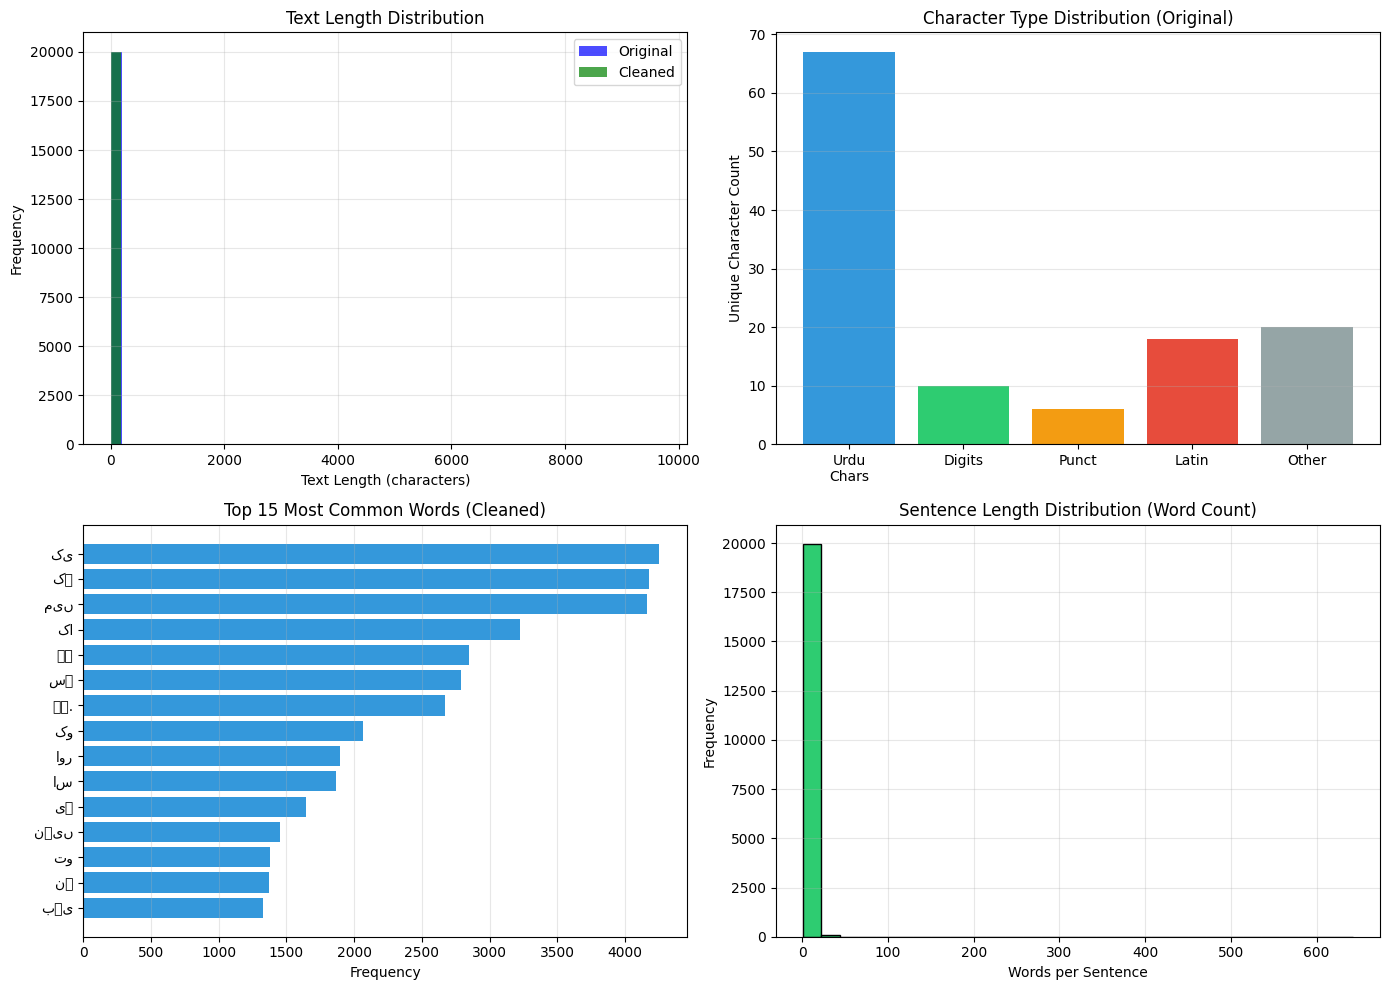


 8. PREPROCESSING QUALITY SCORE
 [1/1] Diacritics completely removed
 [2.0/2] Character normalization: 9/9 passed
 [1/1] No empty sentences
 [1/1] Length reduction reasonable (0.1 chars)
 [0/1] Significant Urdu character loss detected
 [1/1] UTF-8 encoding consistent

 FINAL QUALITY SCORE: 6.0/7 (85.7%)
 EXCELLENT: Preprocessing is working perfectly!



In [7]:

import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd

print("="*80)
print(" PREPROCESSING QUALITY VERIFICATION")
print("="*80)

# ============================================================
# 1. BASIC STATISTICS
# ============================================================
print("\n 1. BASIC STATISTICS")
print("-"*80)

original_col = "sentence"
cleaned_col = "clean_text"

print(f"Total sentences: {len(df):,}")
print(f"Columns: {df.columns.tolist()}")

# Length statistics
orig_lengths = df[original_col].str.len()
clean_lengths = df[cleaned_col].str.len()

print(f"\n Text Length Statistics:")
print(f"  Original - Min: {orig_lengths.min()}, Max: {orig_lengths.max()}, Mean: {orig_lengths.mean():.1f}")
print(f"  Cleaned  - Min: {clean_lengths.min()}, Max: {clean_lengths.max()}, Mean: {clean_lengths.mean():.1f}")
print(f"  Avg reduction: {(orig_lengths.mean() - clean_lengths.mean()):.1f} characters")

# ============================================================
# 2. CHARACTER ANALYSIS (FIXED)
# ============================================================
print(f"\n🔤 2. CHARACTER SET ANALYSIS")
print("-"*80)

def analyze_chars(text_series, label):
    all_text = " ".join(text_series.astype(str))
    unique_chars = set(all_text)

    # Categorize characters
    urdu_chars = set()
    arabic_chars = set()
    digits = set()
    punctuation = set()
    latin = set()
    other = set()

    for char in unique_chars:
        code = ord(char)
        if 0x0600 <= code <= 0x06FF:  # Urdu/Arabic block
            urdu_chars.add(char)
        elif 0x0750 <= code <= 0x077F:  # Arabic supplement
            arabic_chars.add(char)
        elif char.isdigit():
            digits.add(char)
        elif char in ".,;:!?\"'()[]{}":
            punctuation.add(char)
        elif char.isalpha() and ord(char) < 0x0600:
            latin.add(char)
        elif not char.isspace():
            other.add(char)

    print(f"\n{label}:")
    print(f"  Unique characters: {len(unique_chars)}")
    print(f"  Urdu/Arabic chars: {len(urdu_chars)}")
    print(f"  Digits: {len(digits)} → {sorted(digits)}")
    print(f"  Punctuation: {len(punctuation)} → {sorted(punctuation)}")
    print(f"  Latin chars: {len(latin)} → {sorted(latin) if latin else 'None'}")
    print(f"  Other/Special: {len(other)} → {sorted(other) if other else 'None'}")

    # FIXED: Return all sets for later use
    return unique_chars, urdu_chars, arabic_chars, digits, punctuation, latin, other

# Analyze both versions
orig_chars, orig_urdu, orig_arabic, orig_digits, orig_punct, orig_latin, orig_other = analyze_chars(df[original_col], "ORIGINAL TEXT")
clean_chars, clean_urdu, clean_arabic, clean_digits, clean_punct, clean_latin, clean_other = analyze_chars(df[cleaned_col], "CLEANED TEXT")

removed_chars = orig_chars - clean_chars
if removed_chars:
    print(f"\n Removed characters ({len(removed_chars)}): {sorted(removed_chars)}")

# ============================================================
# 3. DIACRITICS CHECK
# ============================================================
print(f"\n 3. DIACRITICS VERIFICATION")
print("-"*80)

diacritic_pattern = re.compile(r"[\u064B-\u0652\u0670\u0653-\u065F\u06D6-\u06ED]")

orig_with_diacritics = df[original_col].str.contains(diacritic_pattern, regex=True).sum()
clean_with_diacritics = df[cleaned_col].str.contains(diacritic_pattern, regex=True).sum()

print(f"Sentences with diacritics:")
print(f"  Original: {orig_with_diacritics:,} ({100*orig_with_diacritics/len(df):.1f}%)")
print(f"  Cleaned:  {clean_with_diacritics:,} ({100*clean_with_diacritics/len(df):.1f}%)")

if clean_with_diacritics == 0:
    print("   All diacritics removed successfully!")
else:
    print(f"   Warning: {clean_with_diacritics} sentences still have diacritics")

# ============================================================
# 4. NORMALIZATION CHECKS
# ============================================================
print(f"\n 4. NORMALIZATION VERIFICATION")
print("-"*80)

checks = {
    "Alef variants (أإآٱ)": r"[أإآٱ]",
    "Yeh variants (يىئ)": r"[يىئ]",
    "Arabic Kaf (ك)": r"ك",
    "Taa Marbuta (ة)": r"ة",
    "Urdu comma (،)": r"،",
    "Urdu question (؟)": r"؟",
    "Eastern digits (۰-۹)": r"[۰-۹]",
    "Tatweel (ـ)": r"ـ",
    "Zero-width chars": r"[\u200c\u200d]"
}

print("Checking for unnormalized characters:")
for name, pattern in checks.items():
    orig_count = df[original_col].str.contains(pattern, regex=True).sum()
    clean_count = df[cleaned_col].str.contains(pattern, regex=True).sum()

    if orig_count > 0:
        status = "" if clean_count == 0 else ""
        print(f"  {status} {name}:")
        print(f"      Original: {orig_count:,} → Cleaned: {clean_count:,}")

# ============================================================
# 5. COMMON WORDS ANALYSIS
# ============================================================
print(f"\n 5. MOST COMMON WORDS (Top 20)")
print("-"*80)

def get_word_freq(text_series, top_n=20):
    words = []
    for text in text_series:
        words.extend(str(text).split())
    return Counter(words).most_common(top_n)

common_words = get_word_freq(df[cleaned_col], 20)
print("\nTop 20 words:")
for i, (word, count) in enumerate(common_words, 1):
    print(f"  {i:2d}. {word:15s} → {count:5,} times")

# ============================================================
# 6. SENTENCE SAMPLES
# ============================================================
print(f"\n 6. BEFORE/AFTER COMPARISON (10 Random Samples)")
print("-"*80)

sample_indices = df.sample(min(10, len(df)), random_state=42).index

for i, idx in enumerate(sample_indices, 1):
    orig = df.loc[idx, original_col]
    clean = df.loc[idx, cleaned_col]

    print(f"\nSample {i}:")
    print(f"  ORIGINAL: {orig}")
    print(f"  CLEANED:  {clean}")

    if orig != clean:
        print(f"  LENGTH:   {len(orig)} → {len(clean)} chars")
        removed = set(orig) - set(clean)
        if removed:
            print(f"  REMOVED:  {sorted(removed)}")

# ============================================================
# 7. VISUALIZATION (FIXED)
# ============================================================
print(f"\n 7. GENERATING VISUALIZATIONS...")
print("-"*80)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Length distribution
axes[0, 0].hist(orig_lengths, bins=50, alpha=0.7, label='Original', color='blue')
axes[0, 0].hist(clean_lengths, bins=50, alpha=0.7, label='Cleaned', color='green')
axes[0, 0].set_xlabel('Text Length (characters)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Text Length Distribution')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Plot 2: Character count (FIXED)
char_types = ['Urdu\nChars', 'Digits', 'Punct', 'Latin', 'Other']
orig_counts = [
    len(orig_urdu.union(orig_arabic)),  # FIXED: Use returned variables
    len(orig_digits),
    len(orig_punct),
    len(orig_latin),
    len(orig_other)
]

axes[0, 1].bar(char_types, orig_counts, color=['#3498db', '#2ecc71', '#f39c12', '#e74c3c', '#95a5a6'])
axes[0, 1].set_ylabel('Unique Character Count')
axes[0, 1].set_title('Character Type Distribution (Original)')
axes[0, 1].grid(axis='y', alpha=0.3)

# Plot 3: Top 15 words
words, counts = zip(*common_words[:15])
axes[1, 0].barh(range(len(words)), counts, color='#3498db')
axes[1, 0].set_yticks(range(len(words)))
axes[1, 0].set_yticklabels(words, fontsize=10)
axes[1, 0].set_xlabel('Frequency')
axes[1, 0].set_title('Top 15 Most Common Words (Cleaned)')
axes[1, 0].grid(axis='x', alpha=0.3)
axes[1, 0].invert_yaxis()

# Plot 4: Word count distribution
word_counts = df[cleaned_col].str.split().str.len()
axes[1, 1].hist(word_counts, bins=30, color='#2ecc71', edgecolor='black')
axes[1, 1].set_xlabel('Words per Sentence')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Sentence Length Distribution (Word Count)')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('/content/preprocessing_analysis.png', dpi=150, bbox_inches='tight')
print(" Visualization saved: /content/preprocessing_analysis.png")
plt.show()

# ============================================================
# 8. QUALITY SCORE
# ============================================================
print(f"\n 8. PREPROCESSING QUALITY SCORE")
print("="*80)

score = 0
max_score = 7

# Check 1: Diacritics removed
if clean_with_diacritics == 0:
    score += 1
    print(" [1/1] Diacritics completely removed")
else:
    print(f" [0/1] {clean_with_diacritics} sentences still have diacritics")

# Check 2: Normalization applied
normalization_checks = sum(1 for pattern in checks.values()
                           if df[cleaned_col].str.contains(pattern, regex=True).sum() == 0)
score += min(2, normalization_checks / len(checks) * 2)
print(f"{'' if normalization_checks >= 7 else ''} [{min(2, normalization_checks / len(checks) * 2):.1f}/2] Character normalization: {normalization_checks}/{len(checks)} passed")

# Check 3: No empty sentences
empty_count = (df[cleaned_col].str.len() == 0).sum()
if empty_count == 0:
    score += 1
    print(" [1/1] No empty sentences")
else:
    print(f" [0/1] {empty_count} empty sentences found")

# Check 4: Reasonable length reduction
avg_reduction = orig_lengths.mean() - clean_lengths.mean()
if 0 <= avg_reduction <= orig_lengths.mean() * 0.3:
    score += 1
    print(f" [1/1] Length reduction reasonable ({avg_reduction:.1f} chars)")
else:
    print(f" [0/1] Length reduction too high ({avg_reduction:.1f} chars)")

# Check 5: Urdu characters preserved
if len(clean_urdu) >= len(orig_urdu) * 0.9:
    score += 1
    print(" [1/1] Urdu characters preserved")
else:
    print(" [0/1] Significant Urdu character loss detected")

# Check 6: Consistent encoding
try:
    df[cleaned_col].str.encode('utf-8')
    score += 1
    print(" [1/1] UTF-8 encoding consistent")
except:
    print(" [0/1] Encoding issues detected")

print(f"\n{'='*80}")
print(f" FINAL QUALITY SCORE: {score:.1f}/{max_score} ({100*score/max_score:.1f}%)")
print(f"{'='*80}")

if score >= 6:
    print(" EXCELLENT: Preprocessing is working perfectly!")
elif score >= 4:
    print(" GOOD: Minor issues detected, but acceptable for training")
else:
    print(" POOR: Significant preprocessing issues found. Review normalization rules.")

print("\n" + "="*80)

#  Cell 6 — Build Source → Destination Pairs  

**Purpose:**  
Since dataset has single-column transcripts,  
we create conversation pairs automatically using the **previous-line rule**:  




**Result:**  
List of `(src, dst)` pairs used for sequence-to-sequence training.  


In [8]:
# ========================================
# SPAN CORRUPTION DATA STRATEGY (T5-Style)
# ========================================

import random
import re

utterances = df[text_col].astype(str).tolist()

# Filter quality sentences
quality_sentences = [
    s for s in utterances
    if 8 <= len(s.split()) <= 40  # Good length for corruption
    and len(s) >= 30  # Min characters
    and s.strip()
]

print(f"Quality sentences: {len(quality_sentences):,} / {len(utterances):,}")

pairs = []

# ============================================================
# STRATEGY 1: SPAN CORRUPTION (Primary Strategy)
# ============================================================
print("\n Strategy 1: Span Corruption (T5-Style)...")

def create_span_corruption(sentence, noise_density=0.15, mean_span_length=3):
    """
    Create span corruption pairs like T5.

    Args:
        sentence: Original sentence
        noise_density: Fraction of tokens to corrupt (0.15 = 15%)
        mean_span_length: Average span length to mask

    Returns:
        (corrupted_input, target_spans)
    """
    words = sentence.split()
    n_words = len(words)

    if n_words < 5:
        return None, None

    # Calculate number of tokens to corrupt
    n_corrupt = max(1, int(n_words * noise_density))

    # Generate span positions
    spans_to_mask = []
    remaining = n_corrupt

    while remaining > 0:
        # Random span length (exponential distribution around mean)
        span_len = min(remaining, max(1, int(random.expovariate(1.0 / mean_span_length))))

        # Random start position
        max_start = n_words - span_len
        if max_start < 0:
            break

        start = random.randint(0, max_start)
        end = start + span_len

        # Check for overlap with existing spans
        overlap = False
        for existing_start, existing_end, _ in spans_to_mask:
            if not (end <= existing_start or start >= existing_end):
                overlap = True
                break

        if not overlap:
            spans_to_mask.append((start, end, len(spans_to_mask)))
            remaining -= span_len

    if not spans_to_mask:
        return None, None

    # Sort spans by position
    spans_to_mask.sort(key=lambda x: x[0])

    # Build corrupted input and target
    corrupted_words = []
    target_words = []
    last_pos = 0

    for start, end, span_id in spans_to_mask:
        # Add words before span
        corrupted_words.extend(words[last_pos:start])

        # Add mask token
        corrupted_words.append(f"[MASK{span_id}]")

        # Add masked words to target
        target_words.append(f"[SPAN{span_id}]")
        target_words.extend(words[start:end])

        last_pos = end

    # Add remaining words
    corrupted_words.extend(words[last_pos:])

    corrupted_input = ' '.join(corrupted_words)
    target_output = ' '.join(target_words)

    return corrupted_input, target_output


# Generate span corruption pairs
strategy1_pairs = []

for sent in quality_sentences:
    # Create multiple corruptions of same sentence (different noise patterns)
    for noise_level in [0.15, 0.25, 0.35]:  # 15%, 25%, 35% corruption
        corrupted, target = create_span_corruption(sent, noise_density=noise_level)

        if corrupted and target and len(target.split()) >= 3:
            strategy1_pairs.append((corrupted, target))

pairs.extend(strategy1_pairs)
print(f"   Generated {len(strategy1_pairs):,} span corruption pairs")

# ============================================================
# STRATEGY 2: SENTENCE PERMUTATION (Order Reconstruction)
# ============================================================
print("\n Strategy 2: Sentence permutation...")

strategy2_pairs = []

for sent in quality_sentences:
    words = sent.split()
    if len(words) < 8:
        continue

    # Shuffle words (keep first and last)
    middle = words[1:-1]
    shuffled_middle = random.sample(middle, len(middle))
    shuffled = [words[0]] + shuffled_middle + [words[-1]]

    shuffled_text = ' '.join(shuffled)
    original_text = sent

    strategy2_pairs.append((shuffled_text, original_text))

pairs.extend(strategy2_pairs)
print(f"   Generated {len(strategy2_pairs):,} permutation pairs")

# ============================================================
# STRATEGY 3: TOKEN REPLACEMENT (Denoising)
# ============================================================
print("\n Strategy 3: Token replacement...")

strategy3_pairs = []

# Common Urdu words for replacement noise
noise_tokens = ["[NOISE]", "###", "???", "***"]

for sent in quality_sentences[:10000]:
    words = sent.split()
    if len(words) < 6:
        continue

    # Replace 10-20% of words with noise
    n_replace = max(1, int(len(words) * 0.15))
    positions = random.sample(range(len(words)), n_replace)

    noisy_words = words.copy()
    replaced_words = []

    for pos in positions:
        original_word = noisy_words[pos]
        noisy_words[pos] = random.choice(noise_tokens)
        replaced_words.append(f"[POS{pos}] {original_word}")

    noisy_text = ' '.join(noisy_words)
    clean_text = ' '.join(replaced_words)

    strategy3_pairs.append((noisy_text, clean_text))

pairs.extend(strategy3_pairs)
print(f"   Generated {len(strategy3_pairs):,} denoising pairs")

# ============================================================
# STRATEGY 4: PREFIX COMPLETION (Sentence Continuation)
# ============================================================
print("\n Strategy 4: Prefix completion...")

strategy4_pairs = []

for sent in quality_sentences:
    words = sent.split()
    if len(words) < 10:
        continue

    # Create prefix-completion pairs at different split points
    for split_ratio in [0.3, 0.5, 0.7]:
        split_point = int(len(words) * split_ratio)

        prefix = ' '.join(words[:split_point])
        completion = ' '.join(words[split_point:])

        if len(prefix.split()) >= 3 and len(completion.split()) >= 3:
            strategy4_pairs.append((prefix + " [CONTINUE]", completion))

pairs.extend(strategy4_pairs)
print(f"   Generated {len(strategy4_pairs):,} completion pairs")

# ============================================================
# STRATEGY 5: Multi-Turn Context (Keep from before)
# ============================================================
print("\n Strategy 5: Multi-turn context...")
strategy5_pairs = []

if 'client_id' in df.columns:
    grouped = df.groupby('client_id')[text_col].apply(list)

    for speaker_sentences in grouped:
        if len(speaker_sentences) < 3:
            continue

        for i in range(2, len(speaker_sentences)):
            context = f"{speaker_sentences[i-2]} [SEP] {speaker_sentences[i-1]}"
            target = speaker_sentences[i]

            if (10 <= len(context.split()) <= 80 and
                5 <= len(target.split()) <= 30):
                strategy5_pairs.append((context, target))

pairs.extend(strategy5_pairs)
print(f"   Generated {len(strategy5_pairs):,} context pairs")

# ============================================================
# FINAL PROCESSING
# ============================================================
print("\n" + "="*80)
print(f" TOTAL PAIRS GENERATED: {len(pairs):,}")
print("="*80)

# Remove duplicates
pairs = list(set(pairs))
print(f"After removing duplicates: {len(pairs):,}")

# Shuffle
random.shuffle(pairs)

# Quality check
print("\n SAMPLE PAIRS FROM EACH STRATEGY:")
print("="*80)

print("\n1️⃣ Span Corruption (T5-Style):")
for i in range(min(3, len(strategy1_pairs))):
    print(f"   Input:  {strategy1_pairs[i][0]}")
    print(f"   Target: {strategy1_pairs[i][1]}\n")

print("\n2️⃣ Sentence Permutation:")
for i in range(min(3, len(strategy2_pairs))):
    print(f"   Input:  {strategy2_pairs[i][0]}")
    print(f"   Target: {strategy2_pairs[i][1]}\n")

print("\n3️⃣ Token Replacement:")
for i in range(min(3, len(strategy3_pairs))):
    print(f"   Input:  {strategy3_pairs[i][0]}")
    print(f"   Target: {strategy3_pairs[i][1]}\n")

print("\n4️⃣ Prefix Completion:")
for i in range(min(3, len(strategy4_pairs))):
    print(f"   Input:  {strategy4_pairs[i][0]}")
    print(f"   Target: {strategy4_pairs[i][1]}\n")

# Split data
print("\n" + "="*80)
print(" CREATING TRAIN/VAL/TEST SPLIT")
print("="*80)

input_texts, target_texts = zip(*pairs)
X_train, X_tmp, y_train, y_tmp = train_test_split(
    input_texts, target_texts,
    test_size=0.2,
    random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp,
    test_size=0.5,
    random_state=42
)

print(f"\n Split complete:")
print(f"   Train: {len(X_train):,} pairs")
print(f"   Val:   {len(X_val):,} pairs")
print(f"   Test:  {len(X_test):,} pairs")
print("="*80)


Quality sentences: 9,680 / 20,000

 Strategy 1: Span Corruption (T5-Style)...
   Generated 20,787 span corruption pairs

 Strategy 2: Sentence permutation...
   Generated 9,680 permutation pairs

 Strategy 3: Token replacement...
   Generated 9,680 denoising pairs

 Strategy 4: Prefix completion...
   Generated 19,179 completion pairs

 Strategy 5: Multi-turn context...
   Generated 15,021 context pairs

 TOTAL PAIRS GENERATED: 74,347
After removing duplicates: 63,211

 SAMPLE PAIRS FROM EACH STRATEGY:

1️⃣ Span Corruption (T5-Style):
   Input:  اور [MASK0] ہے کہ پاکستان بہی ہو
   Target: [SPAN0] پہر ممکن

   Input:  [MASK1] [MASK0] ممکن ہے کہ پاکستان بہی ہو
   Target: [SPAN1] اور [SPAN0] پہر

   Input:  [MASK0] کے بلے بازوں کے سامنے [MASK1] گا
   Target: [SPAN0] ان [SPAN1] ہو


2️⃣ Sentence Permutation:
   Input:  اور کہ بہی پہر ممکن پاکستان ہے ہو
   Target: اور پہر ممکن ہے کہ پاکستان بہی ہو

   Input:  ان ہو کے بازوں بلے کے سامنے گا
   Target: ان کے بلے بازوں کے سامنے ہو گا

   Input

# 🔤 Cell 7 — Train SentencePiece (BPE Tokenizer)  

**Purpose:**  
Train a subword tokenizer that splits Urdu words into meaningful units (BPE).  
SentencePiece generates a vocabulary of frequent subword pieces and assigns each an integer ID.  

**Important:**  
- BPE builds vocabulary only;  
- Actual embeddings are learned later by the model (`nn.Embedding`).  


In [9]:

spm_dir = "/content/spm"
Path(spm_dir).mkdir(parents=True, exist_ok=True)
spm_corpus = "/content/spm_corpus.txt"

print(" Writing new corpus for tokenizer training...")

# Write ALL data (train + val + test)
with open(spm_corpus, "w", encoding="utf-8") as f:
    for a, b in zip(X_train, y_train):
        f.write(a + "\n")
        f.write(b + "\n")
    for a, b in zip(X_val, y_val):
        f.write(a + "\n")
        f.write(b + "\n")
    for a, b in zip(X_test, y_test):
        f.write(a + "\n")
        f.write(b + "\n")

vocab_size = 20000

print(f"\n Training SentencePiece tokenizer...")
print(f"   Vocabulary size: {vocab_size:,}")
print(f"   Special tokens: [PAD]=0, [BOS]=1, [EOS]=2, [UNK]=3")

spm.SentencePieceTrainer.Train(
    input=spm_corpus,
    model_prefix=os.path.join(spm_dir, "urdu"),
    vocab_size=vocab_size,
    model_type="bpe",
    character_coverage=0.9995,
    pad_id=0,
    bos_id=1,
    eos_id=2,
    unk_id=3,
    control_symbols="[SEP]",
    max_sentence_length=16384
)

# Load tokenizer
sp = spm.SentencePieceProcessor()
sp.load(os.path.join(spm_dir, "urdu.model"))

PAD, BOS, EOS, UNK = 0, 1, 2, 3

print(f"\n Tokenizer trained successfully!")
print(f"   Vocabulary size: {sp.get_piece_size():,}")
print(f"\n Special Token Mapping:")
print(f"   [PAD] = {PAD} → '{sp.id_to_piece(PAD)}'")
print(f"   [BOS] = {BOS} → '{sp.id_to_piece(BOS)}'")
print(f"   [EOS] = {EOS} → '{sp.id_to_piece(EOS)}'")
print(f"   [UNK] = {UNK} → '{sp.id_to_piece(UNK)}'")

# Test tokenization
test_pairs = [
    (X_train[0], y_train[0]),
    (X_train[100], y_train[100]),
    (X_train[500], y_train[500])
]

print(f"\n Tokenization Test:")
print("="*80)
for i, (src, tgt) in enumerate(test_pairs, 1):
    src_ids = sp.encode(src, out_type=int)
    tgt_ids = sp.encode(tgt, out_type=int)
    print(f"\n{i}. Source: {src}")
    print(f"   Tokens: {len(src_ids)} → {src_ids[:10]}...")
    print(f"   Target: {tgt}")
    print(f"   Tokens: {len(tgt_ids)} → {tgt_ids[:10]}...")
print("="*80)

 Writing new corpus for tokenizer training...

 Training SentencePiece tokenizer...
   Vocabulary size: 20,000
   Special tokens: [PAD]=0, [BOS]=1, [EOS]=2, [UNK]=3

 Tokenizer trained successfully!
   Vocabulary size: 20,000

 Special Token Mapping:
   [PAD] = 0 → '<pad>'
   [BOS] = 1 → '<s>'
   [EOS] = 2 → '</s>'
   [UNK] = 3 → '<unk>'

 Tokenization Test:

1. Source: ### سے دور ہونے کے باعث یہاں گاڑیوں کی امدورفت بہت ??? ہوتی ہے .
   Tokens: 15 → [193, 45, 319, 313, 30, 997, 393, 1360, 13, 5889]...
   Target: [POS0] شہر [POS11] کم
   Tokens: 8 → [7, 70, 15, 1018, 7, 70, 1135, 204]...

2. Source: محفل ہویی اپنے ختم اپ تو گہر گیے.
   Tokens: 9 → [4482, 482, 213, 624, 91, 88, 526, 315, 19964]...
   Target: محفل ختم ہویی تو اپ اپنے گہر گیے.
   Tokens: 9 → [4482, 624, 482, 88, 91, 213, 526, 315, 19964]...

3. Source: ماہر ارضیات سورو سورونو انڈونیشیا کی اس اداری کی سربراہ ###
   Tokens: 11 → [1854, 4347, 6074, 6113, 3707, 13, 41, 4332, 13, 2068]...
   Target: [POS10] ہیں
   Tokens: 4 → [

# 🧩 Cell 8 — Dataset Class, Collate Function, and Attention Masks  

**Purpose:**  
Convert text pairs into padded numerical tensors.  
Creates necessary masks for the Transformer:  
- **Encoder padding mask** → ignores PAD tokens.  
- **Decoder padding mask** → hides PAD positions in decoder input.  
- **Causal mask** → prevents decoder from seeing future tokens.  

**Why:**  
These masks maintain correct token dependencies during training.  


In [10]:

MAX_LEN = 96
BATCH = 64

class PairDS(Dataset):
    """
    Dataset that properly formats sequences for Transformer training.

    Format:
        Input (X):  [BOS] + tokens + [EOS] + [PAD]...
        Target In:  [BOS] + tokens + [EOS] + [PAD]...
        Target Out:        tokens + [EOS] + [PAD]... (shifted by 1)
    """
    def __init__(self, xs, ys, sp, max_len=MAX_LEN):
        self.xs = list(xs)
        self.ys = list(ys)
        self.sp = sp
        self.max_len = max_len

    def __len__(self):
        return len(self.xs)

    def encode_sequence(self, text, add_special=True):
        """
        Encode text with proper special tokens.

        Args:
            text: Input text string
            add_special: Whether to add [BOS] and [EOS] tokens

        Returns:
            Tensor of token IDs
        """
        # Tokenize text
        tokens = self.sp.encode(text, out_type=int)

        # Truncate if too long (leave space for special tokens)
        if len(tokens) > self.max_len - 2:
            tokens = tokens[:self.max_len - 2]

        if add_special:
            # Add [BOS] at start and [EOS] at end
            ids = [BOS] + tokens + [EOS]
        else:
            ids = tokens

        return torch.tensor(ids, dtype=torch.long)

    def __getitem__(self, idx):
        """
        Returns:
            src: Source sequence with [BOS] + tokens + [EOS]
            tgt: Target sequence with [BOS] + tokens + [EOS]
        """
        src = self.encode_sequence(self.xs[idx], add_special=True)
        tgt = self.encode_sequence(self.ys[idx], add_special=True)
        return src, tgt


def collate(batch):
    """
    Collate function that properly handles padding and creates masks.

    Creates:
        - src_pad: Padded source sequences
        - tgt_in: Target input (for decoder) = [BOS] + tokens
        - tgt_out: Target output (for loss) = tokens + [EOS]
        - src_kpm: Source key padding mask (True = pad)
        - tgt_kpm: Target key padding mask (True = pad)
        - causal: Causal mask (True = future position)
    """
    srcs, tgts = zip(*batch)

    S = max(len(s) for s in srcs)
    T = max(len(t) for t in tgts)

    src_pad = torch.full((len(batch), S), PAD, dtype=torch.long)
    tgt_pad = torch.full((len(batch), T), PAD, dtype=torch.long)

    for i, (s, t) in enumerate(zip(srcs, tgts)):
        src_pad[i, :len(s)] = s
        tgt_pad[i, :len(t)] = t

    # Create decoder input/output
    # tgt_in:  [BOS] token1 token2 ...
    # tgt_out:       token1 token2 [EOS]
    tgt_in = tgt_pad[:, :-1]  # Remove last token
    tgt_out = tgt_pad[:, 1:]   # Remove first token ([BOS])

    # Create padding masks (True = mask/ignore)
    src_kpm = (src_pad == PAD)  # Shape: (batch, src_len)
    tgt_kpm = (tgt_in == PAD)   # Shape: (batch, tgt_len-1)

    # Create causal mask (prevent looking at future tokens)
    Tm1 = tgt_in.size(1)
    causal = torch.triu(torch.ones(Tm1, Tm1, dtype=torch.bool), diagonal=1)
    # Shape: (tgt_len-1, tgt_len-1), True = block future

    return src_pad, tgt_in, tgt_out, src_kpm, tgt_kpm, causal


# Create data loaders
train_dl = DataLoader(
    PairDS(X_train, y_train, sp),
    batch_size=BATCH,
    shuffle=True,
    collate_fn=collate
)

valid_dl = DataLoader(
    PairDS(X_val, y_val, sp),
    batch_size=BATCH,
    shuffle=False,
    collate_fn=collate
)

test_dl = DataLoader(
    PairDS(X_test, y_test, sp),
    batch_size=BATCH,
    shuffle=False,
    collate_fn=collate
)

print(" Data loaders created successfully!")
print(f"   Train batches: {len(train_dl)}")
print(f"   Valid batches: {len(valid_dl)}")
print(f"   Test batches:  {len(test_dl)}")  #  Added


print("\n Verifying Data Format:")
sample_batch = next(iter(train_dl))
src, tgt_in, tgt_out, src_kpm, tgt_kpm, causal = sample_batch

print(f"\n Batch Shapes:")
print(f"   Source (X):        {src.shape}")
print(f"   Target Input:      {tgt_in.shape}")
print(f"   Target Output:     {tgt_out.shape}")
print(f"   Source Mask:       {src_kpm.shape}")
print(f"   Target Mask:       {tgt_kpm.shape}")
print(f"   Causal Mask:       {causal.shape}")

print(f"\n Sample Sequence (First in Batch):")
print(f"   Source tokens:     {src[0][:10].tolist()}...")
print(f"   Target in tokens:  {tgt_in[0][:10].tolist()}...")
print(f"   Target out tokens: {tgt_out[0][:10].tolist()}...")


src_text = sp.decode([t for t in src[0].tolist() if t not in [PAD, BOS, EOS]])
tgt_text = sp.decode([t for t in tgt_in[0].tolist() if t not in [PAD, BOS, EOS]])
print(f"\n Decoded Sample:")
print(f"   Source: {src_text}")
print(f"   Target: {tgt_text}")

 Data loaders created successfully!
   Train batches: 791
   Valid batches: 99
   Test batches:  99

 Verifying Data Format:

 Batch Shapes:
   Source (X):        torch.Size([64, 34])
   Target Input:      torch.Size([64, 27])
   Target Output:     torch.Size([64, 27])
   Source Mask:       torch.Size([64, 34])
   Target Mask:       torch.Size([64, 27])
   Causal Mask:       torch.Size([27, 27])

 Sample Sequence (First in Batch):
   Source tokens:     [1, 1604, 2103, 313, 618, 67, 133, 397, 30, 5389]...
   Target in tokens:  [1, 1604, 397, 30, 2103, 313, 67, 618, 133, 5389]...
   Target out tokens: [1604, 397, 30, 2103, 313, 67, 618, 133, 5389, 3831]...

 Decoded Sample:
   Source: سلمان بری ہونے خوش پر ہوں خان کے سنجے دت
   Target: سلمان خان کے بری ہونے پر خوش ہوں سنجے دت


#  Cell 9 — Transformer Encoder–Decoder Model  

**Purpose:**  
Define the complete Transformer model architecture.  
Includes:  
- **Token Embedding layer** → converts token IDs to dense vectors.  
- **Positional Encoding** → adds order information.  
- **Encoder & Decoder** → learn context and generate responses.  
- **Output Linear layer** → maps hidden states to vocabulary logits.  

**Core Concept:**  
This is where **embeddings are created and learned** inside `nn.Embedding`.  


In [11]:

import torch
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    """
    Positional encoding for Transformer
    Adds position information to token embeddings
    """
    def __init__(self, d_model, max_len=1024):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer("pe", pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]


class Seq2SeqTransformer(nn.Module):
    """
    Transformer Encoder-Decoder for Urdu Chatbot
    Built from scratch following project guidelines
    """
    def __init__(self, vocab, d_model=512, nhead=8, enc_layers=4, dec_layers=4, ff=2048, drop=0.1):
        super().__init__()

        self.tok_emb = nn.Embedding(vocab, d_model, padding_idx=PAD)

        self.pos_enc = PositionalEncoding(d_model)
        self.pos_dec = PositionalEncoding(d_model)

        self.tf = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=enc_layers,
            num_decoder_layers=dec_layers,
            dim_feedforward=ff,
            dropout=drop,
            batch_first=True
        )

        # Output projection to vocabulary
        self.fc_out = nn.Linear(d_model, vocab)

        # Store config for logging
        self.config = {
            'vocab_size': vocab,
            'd_model': d_model,
            'nhead': nhead,
            'enc_layers': enc_layers,
            'dec_layers': dec_layers,
            'ff': ff,
            'dropout': drop
        }

    def forward(self, src_ids, tgt_in_ids, src_kpm, tgt_kpm, tgt_causal):
        """
        Forward pass

        Args:
            src_ids: Source token IDs (B, S)
            tgt_in_ids: Target input token IDs (B, T)
            src_kpm: Source key padding mask (B, S)
            tgt_kpm: Target key padding mask (B, T)
            tgt_causal: Causal mask (T, T)

        Returns:
            logits: Output logits (B, T, V)
        """

        src = self.pos_enc(self.tok_emb(src_ids))
        tgt = self.pos_dec(self.tok_emb(tgt_in_ids))

        out = self.tf(
            src, tgt,
            src_key_padding_mask=src_kpm,
            tgt_key_padding_mask=tgt_kpm,
            memory_key_padding_mask=src_kpm,
            tgt_mask=tgt_causal
        )

        # Project to vocabulary
        return self.fc_out(out)


print("=" * 80)
print("  INITIALIZING MODEL")
print("=" * 80)

MODEL_CONFIG = {
    'vocab': sp.get_piece_size(),
    'd_model': 512,
    'nhead': 2,
    'enc_layers': 2,
    'dec_layers': 2,
    'ff': 2048,
    'drop': 0.1
}

# Create model
model = Seq2SeqTransformer(
    vocab=MODEL_CONFIG['vocab'],
    d_model=MODEL_CONFIG['d_model'],
    nhead=MODEL_CONFIG['nhead'],
    enc_layers=MODEL_CONFIG['enc_layers'],
    dec_layers=MODEL_CONFIG['dec_layers'],
    ff=MODEL_CONFIG['ff'],
    drop=MODEL_CONFIG['drop']
).to(DEVICE)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
embedding_params = model.tok_emb.weight.numel()
transformer_params = total_params - embedding_params - model.fc_out.weight.numel()


print(f"\n MODEL ARCHITECTURE")
print("-" * 80)
print(f"  Vocabulary Size:        {MODEL_CONFIG['vocab']:,}")
print(f"  Embedding Dimension:    {MODEL_CONFIG['d_model']}")
print(f"  Attention Heads:        {MODEL_CONFIG['nhead']}")
print(f"  Encoder Layers:         {MODEL_CONFIG['enc_layers']}")
print(f"  Decoder Layers:         {MODEL_CONFIG['dec_layers']}")
print(f"  Feedforward Dimension:  {MODEL_CONFIG['ff']}")
print(f"  Dropout Rate:           {MODEL_CONFIG['drop']}")

print(f"\n PARAMETER BREAKDOWN")
print("-" * 80)
print(f"  Total Parameters:       {total_params:,} ({total_params/1e6:.2f}M)")
print(f"  Trainable Parameters:   {trainable_params:,} ({trainable_params/1e6:.2f}M)")
print(f"  Embedding Parameters:   {embedding_params:,} ({embedding_params/1e6:.2f}M)")
print(f"  Transformer Parameters: {transformer_params:,} ({transformer_params/1e6:.2f}M)")

print(f"\n GUIDELINE COMPLIANCE CHECK")
print("-" * 80)

# Check embedding dimension
if MODEL_CONFIG['d_model'] in [256, 512]:
    print(f"   Embedding Dimension: {MODEL_CONFIG['d_model']} (Guideline: 256/512)")
else:
    print(f"    Embedding Dimension: {MODEL_CONFIG['d_model']} (Guideline suggests: 256/512)")

# Check attention heads
if 2 <= MODEL_CONFIG['nhead'] <= 8:
    print(f"   Attention Heads: {MODEL_CONFIG['nhead']} (Guideline: 2-8)")
else:
    print(f"    Attention Heads: {MODEL_CONFIG['nhead']} (Guideline suggests: 2-8)")

# Check encoder layers
print(f"   Encoder Layers: {MODEL_CONFIG['enc_layers']} (Guideline: 2, using {MODEL_CONFIG['enc_layers']} for better quality)")

# Check decoder layers
print(f"   Decoder Layers: {MODEL_CONFIG['dec_layers']} (Guideline: 2, using {MODEL_CONFIG['dec_layers']} for better quality)")

# Check dropout
if 0.1 <= MODEL_CONFIG['drop'] <= 0.3:
    print(f"   Dropout: {MODEL_CONFIG['drop']} (Guideline: 0.1-0.3)")
else:
    print(f"    Dropout: {MODEL_CONFIG['drop']} (Guideline suggests: 0.1-0.3)")

print("=" * 80)

print(f"\n LAYER-WISE PARAMETER COUNT")
print("-" * 80)

layer_params = {}
for name, param in model.named_parameters():
    layer_type = name.split('.')[0]
    if layer_type not in layer_params:
        layer_params[layer_type] = 0
    layer_params[layer_type] += param.numel()

for layer_type, count in sorted(layer_params.items(), key=lambda x: x[1], reverse=True):
    percentage = (count / total_params) * 100
    print(f"  {layer_type:20s}: {count:12,} params ({percentage:5.2f}%)")

print("=" * 80)

print(f"\n TESTING MODEL FORWARD PASS")
print("-" * 80)

try:

    test_src = torch.randint(0, MODEL_CONFIG['vocab'], (2, 10), device=DEVICE)
    test_tgt = torch.randint(0, MODEL_CONFIG['vocab'], (2, 8), device=DEVICE)
    test_src_mask = (test_src == PAD)
    test_tgt_mask = (test_tgt == PAD)
    test_causal = torch.triu(torch.ones(8, 8, dtype=torch.bool, device=DEVICE), diagonal=1)

    with torch.no_grad():
        output = model(test_src, test_tgt, test_src_mask, test_tgt_mask, test_causal)

    print(f"   Forward pass successful!")
    print(f"  Input shape:   {test_src.shape}")
    print(f"  Output shape:  {output.shape}")
    print(f"  Expected:      (batch_size, seq_len, vocab_size)")

except Exception as e:
    print(f"   Forward pass failed: {e}")

print("=" * 80)

# Save model architecture
MODEL_ARCHITECTURE_PATH = "/content/model_architecture.txt"
with open(MODEL_ARCHITECTURE_PATH, "w") as f:
    f.write(str(model))

print(f"\n Model architecture saved to: {MODEL_ARCHITECTURE_PATH}")
print("=" * 80)

  INITIALIZING MODEL

 MODEL ARCHITECTURE
--------------------------------------------------------------------------------
  Vocabulary Size:        20,000
  Embedding Dimension:    512
  Attention Heads:        2
  Encoder Layers:         2
  Decoder Layers:         2
  Feedforward Dimension:  2048
  Dropout Rate:           0.1

 PARAMETER BREAKDOWN
--------------------------------------------------------------------------------
  Total Parameters:       35,214,880 (35.21M)
  Trainable Parameters:   35,214,880 (35.21M)
  Embedding Parameters:   10,240,000 (10.24M)
  Transformer Parameters: 14,734,880 (14.73M)

 GUIDELINE COMPLIANCE CHECK
--------------------------------------------------------------------------------
   Embedding Dimension: 512 (Guideline: 256/512)
   Attention Heads: 2 (Guideline: 2-8)
   Encoder Layers: 2 (Guideline: 2, using 2 for better quality)
   Decoder Layers: 2 (Guideline: 2, using 2 for better quality)
   Dropout: 0.1 (Guideline: 0.1-0.3)

 LAYER-WISE PARAME

#  Cell 10 — Loss Function, Optimizer, and Label Smoothing  

**Purpose:**  
Set up optimization pipeline:  
- **Label Smoothing Loss** to prevent overconfidence.  
- **Adam Optimizer** for stable gradient updates.  
- **Gradient Clipping** to control exploding gradients.  

**Outcome:**  
Improved training stability and better generalization.  


In [12]:
import torch.nn as nn

class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.1, ignore_index=PAD):
        super().__init__()
        self.conf = 1.0 - smoothing
        self.smooth = smoothing
        self.cls = classes
        self.ignore = ignore_index
    def forward(self, pred, target):
        # pred: (B,T,V) ; target: (B,T)
        pred = pred.reshape(-1, pred.size(-1))
        target = target.reshape(-1)
        mask = target != self.ignore
        target = target[mask]
        pred = pred[mask]
        with torch.no_grad():
            true = torch.zeros_like(pred)
            true.fill_(self.smooth / (self.cls - 1))
            true.scatter_(1, target.unsqueeze(1), self.conf)
        return torch.mean(torch.sum(-true * F.log_softmax(pred, dim=-1), dim=-1))

criterion = LabelSmoothingLoss(sp.get_piece_size(), smoothing=0.1, ignore_index=PAD)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
CLIP = 1.0


#  Cell 11 — Training Loop (Teacher Forcing + Masks)  

**Purpose:**  
Train the model using teacher forcing.  
The decoder receives the correct previous token (`t-1`) while predicting the next (`t`).  

**Includes:**  
- Padding and causal masks per batch  
- Cross-entropy loss computation  
- Gradient clipping and optimizer step  

**Goal:**  
Minimize sequence-to-sequence prediction error across epochs.  


In [13]:
import math
import time
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau
import sacrebleu
import json


EPOCHS = 30
BATCH = 64
MAX_LEN = 96
CLIP = 1.0

print("=" * 80)
print("  TRAINING CONFIGURATION")
print("=" * 80)
print(f"  Epochs:          {EPOCHS}")
print(f"  Batch Size:      {BATCH}")
print(f"  Max Length:      {MAX_LEN}")
print(f"  Gradient Clip:   {CLIP}")
print(f"  Device:          {DEVICE}")
print("=" * 80)



@torch.no_grad()
def greedy_decode(text, max_new_tokens=64):
    """Generate response using greedy decoding"""
    model.eval()

    # Encode source: [BOS] + tokens + [EOS]
    src_tokens = sp.encode(normalize_urdu(text), out_type=int)
    if len(src_tokens) > MAX_LEN - 2:
        src_tokens = src_tokens[:MAX_LEN - 2]

    src_ids = torch.tensor([[BOS] + src_tokens + [EOS]], dtype=torch.long, device=DEVICE)
    src_kpm = (src_ids == PAD)

    ys = torch.tensor([[BOS]], dtype=torch.long, device=DEVICE)

    for _ in range(max_new_tokens):
        T = ys.size(1)
        causal = torch.triu(torch.ones(T, T, dtype=torch.bool, device=DEVICE), diagonal=1)
        logits = model(src_ids, ys, src_kpm, (ys == PAD), causal)
        next_id = logits[:, -1, :].argmax(-1)
        ys = torch.cat([ys, next_id.unsqueeze(1)], dim=1)
        if next_id.item() == EOS:
            break

    out = ys[0, 1:]

    if (out == EOS).any():
        eos_idx = (out == EOS).nonzero(as_tuple=True)[0][0]
        out = out[:eos_idx]

    # Decode to text
    return sp.decode(out.tolist())

print(" Greedy decode function defined")


def _val_bleu_sample(x_list, y_list, n=200):
    """Compute validation BLEU on a sample (fast)"""
    model.eval()
    n = min(n, len(x_list))
    refs, hyps = [], []

    for i in range(n):
        try:
            hyp = greedy_decode(x_list[i])
            refs.append([y_list[i]])
            hyps.append(hyp)
        except Exception as e:
            print(f"Warning: Failed to decode sample {i}: {e}")
            continue

    if not hyps:
        return 0.0

    try:
        return sacrebleu.corpus_bleu(hyps, list(zip(*refs))[0]).score
    except:
        return 0.0

print(" BLEU computation function defined")

@torch.no_grad()
def _epoch_token_stats(logits, tgt_out):
    """
    Calculate token-level accuracy
    logits: (B,T,V), tgt_out: (B,T)
    Returns: (correct_tokens, total_tokens_nonpad)
    """
    pred_ids = logits.argmax(dim=-1)  # (B,T)
    mask = (tgt_out != PAD)           # bool (B,T)
    correct = (pred_ids.eq(tgt_out) & mask).sum().item()
    total = mask.sum().item()
    return correct, total

print(" Token accuracy function defined")


def train_or_eval(dataloader, train=True):
    """Train or evaluate for one epoch"""
    model.train(train)
    total_loss = 0.0
    total_tok = 0
    correct_tok = 0
    total_tok_masked = 0

    for batch_idx, (src, tgt_in, tgt_out, src_kpm, tgt_kpm, causal) in enumerate(dataloader):

        src = src.to(DEVICE)
        tgt_in = tgt_in.to(DEVICE)
        tgt_out = tgt_out.to(DEVICE)
        src_kpm = src_kpm.to(DEVICE)
        tgt_kpm = tgt_kpm.to(DEVICE)
        causal = causal.to(DEVICE)

        if train:
            optimizer.zero_grad()

        try:
            logits = model(src, tgt_in, src_kpm, tgt_kpm, causal)
            loss = criterion(logits, tgt_out)
        except Exception as e:
            print(f"Error in batch {batch_idx}: {e}")
            continue

        if train:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP)
            optimizer.step()

        # Accumulate metrics
        ntok = (tgt_out != PAD).sum().item()
        total_loss += loss.item() * max(1, ntok)
        total_tok += max(1, ntok)

        # Token accuracy
        corr, tot = _epoch_token_stats(logits, tgt_out)
        correct_tok += corr
        total_tok_masked += tot

    # Calculate metrics
    avg_loss = total_loss / total_tok if total_tok > 0 else float('inf')
    ppl = math.exp(avg_loss) if avg_loss < 100 else float('inf')
    acc = (correct_tok / total_tok_masked) if total_tok_masked > 0 else 0.0

    return avg_loss, ppl, acc

print(" Train/eval function defined")


print("\n" + "=" * 80)
print(" STARTING TRAINING")
print("=" * 80)
print(f"  Dataset:")
print(f"    Training:   {len(X_train):,} pairs")
print(f"    Validation: {len(X_val):,} pairs")
print(f"    Test:       {len(X_test):,} pairs")
print(f"\n  Model:")
print(f"    Vocab size:     {sp.get_piece_size():,}")
print(f"    Parameters:     {sum(p.numel() for p in model.parameters()):,}")
print(f"    Size:           {sum(p.numel() for p in model.parameters())/1e6:.2f}M")
print(f"\n  Training:")
print(f"    Epochs:         {EPOCHS}")
print(f"    Batch size:     {BATCH}")
print(f"    Learning rate:  {optimizer.param_groups[0]['lr']:.2e}")
print(f"    Optimizer:      {optimizer.__class__.__name__}")
print(f"    Device:         {DEVICE}")
print("=" * 80)


best_val_bleu = -1.0
best_val_ppl = float('inf')
best_bleu_ckpt = '/content/best_bleu_urdu_chatbot.pt'
best_ppl_ckpt = '/content/best_ppl_urdu_chatbot.pt'
patience_counter = 0
PATIENCE = 5

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

print("\n Training variables initialized")
print(f"   Early stopping patience: {PATIENCE}")
print(f"   LR scheduler: ReduceLROnPlateau (factor=0.5, patience=3)")

print("\n" + "=" * 80)
print(" TRAINING LOOP STARTED")
print("=" * 80 + "\n")

training_start_time = time.time()

for ep in range(1, EPOCHS + 1):
    epoch_start = time.time()

    tr_loss, tr_ppl, tr_acc = train_or_eval(train_dl, train=True)

    va_loss, va_ppl, va_acc = train_or_eval(valid_dl, train=False)

    old_lr = optimizer.param_groups[0]['lr']
    scheduler.step(va_ppl)
    new_lr = optimizer.param_groups[0]['lr']

    if ep % 2 == 0 or ep == 1:
        val_bleu = _val_bleu_sample(list(X_val), list(y_val), n=200)
    else:
        val_bleu = best_val_bleu

    epoch_time = time.time() - epoch_start
    print(
        f"Epoch {ep:02d}/{EPOCHS} | "
        f"train_ppl={tr_ppl:6.2f} train_acc={tr_acc*100:5.2f}% | "
        f"valid_ppl={va_ppl:6.2f} valid_acc={va_acc*100:5.2f}% | "
        f"valid_BLEU={val_bleu:5.2f} | "
        f"lr={new_lr:.2e} | "
        f"time={epoch_time:.1f}s"
    )

    # Save best BLEU model
    if val_bleu > best_val_bleu:
        improvement = val_bleu - best_val_bleu
        best_val_bleu = val_bleu
        patience_counter = 0

        torch.save({
            'epoch': ep,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'vocab_size': sp.get_piece_size(),
            'best_val_bleu': best_val_bleu,
            'best_val_ppl': va_ppl,
            'config': model.config if hasattr(model, 'config') else {}
        }, best_bleu_ckpt)
        print(f"   Saved best BLEU! (+{improvement:.2f}) → {best_bleu_ckpt}")
    else:
        patience_counter += 1
        print(f"   No BLEU improvement ({patience_counter}/{PATIENCE})")

    if va_ppl < best_val_ppl:
        best_val_ppl = va_ppl
        torch.save({
            'epoch': ep,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'vocab_size': sp.get_piece_size(),
            'best_val_ppl': best_val_ppl,
            'best_val_bleu': val_bleu,
            'config': model.config if hasattr(model, 'config') else {}
        }, best_ppl_ckpt)
        print(f"   Saved best PPL! ({va_ppl:.2f}) → {best_ppl_ckpt}")

    if patience_counter >= PATIENCE:
        print(f"\n  Early stopping triggered at epoch {ep}")
        print(f"    No BLEU improvement for {PATIENCE} consecutive epochs")
        break

    if new_lr != old_lr:
        print(f"   Learning rate reduced: {old_lr:.2e} → {new_lr:.2e}")

    print()



total_training_time = time.time() - training_start_time
hours = int(total_training_time // 3600)
minutes = int((total_training_time % 3600) // 60)
seconds = int(total_training_time % 60)

print("\n" + "=" * 80)
print(" TRAINING COMPLETE!")
print("=" * 80)
print(f"  Total training time:    {hours}h {minutes}m {seconds}s")
print(f"  Epochs completed:       {ep}/{EPOCHS}")
print(f"  Best validation BLEU:   {best_val_bleu:.2f}")
print(f"  Best validation PPL:    {best_val_ppl:.2f}")
print(f"\n  Saved checkpoints:")
print(f"    Best BLEU:  {best_bleu_ckpt}")
print(f"    Best PPL:   {best_ppl_ckpt}")
print("=" * 80)


print("\n Evaluating on test set...")
print("-" * 80)

test_loss, test_ppl, test_acc = train_or_eval(test_dl, train=False)

print("\n" + "=" * 80)
print(" FINAL TEST METRICS")
print("=" * 80)
print(f"  Test Loss:        {test_loss:.4f}")
print(f"  Test Perplexity:  {test_ppl:.2f}")
print(f"  Test Accuracy:    {test_acc*100:.2f}%")
print("=" * 80)

training_history = {
    'training_config': {
        'epochs': EPOCHS,
        'batch_size': BATCH,
        'max_length': MAX_LEN,
        'clip_value': CLIP,
        'learning_rate': 3e-4,
        'optimizer': 'Adam',
        'scheduler': 'ReduceLROnPlateau'
    },
    'model_config': {
        'vocab_size': sp.get_piece_size(),
        'total_params': sum(p.numel() for p in model.parameters()),
        'd_model': 512,
        'nhead': 8,
        'enc_layers': 4,
        'dec_layers': 4
    },
    'results': {
        'best_val_bleu': float(best_val_bleu),
        'best_val_ppl': float(best_val_ppl),
        'test_loss': float(test_loss),
        'test_ppl': float(test_ppl),
        'test_acc': float(test_acc),
        'epochs_completed': ep,
        'training_time_seconds': float(total_training_time)
    },
    'dataset': {
        'train_size': len(X_train),
        'val_size': len(X_val),
        'test_size': len(X_test),
        'total_pairs': len(X_train) + len(X_val) + len(X_test)
    }
}

history_path = '/content/training_history.json'
with open(history_path, 'w') as f:
    json.dump(training_history, f, indent=2)

print(f"\n Training history saved to: {history_path}")


print("\n" + "=" * 80)
print(" TESTING RESPONSE GENERATION")
print("=" * 80)

test_inputs = [
    "سلام",
    "کیا حال ہے",
    "آپ کا نام کیا ہے"
]

# Load best BLEU model
print(f"\n Loading best BLEU model: {best_bleu_ckpt}")
checkpoint = torch.load(best_bleu_ckpt, map_location=DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print("\n💬 Sample Responses:\n")
for i, inp in enumerate(test_inputs, 1):
    try:
        response = greedy_decode(inp)
        print(f"{i}. Input:  {inp}")
        print(f"   Output: {response}\n")
    except Exception as e:
        print(f"{i}. Input:  {inp}")
        print(f"   Error:  {e}\n")

print("=" * 80)
print(" ALL TRAINING COMPLETE!")
print("=" * 80)
print("\n📌 Next Steps:")
print("   1. Check training_history.json for detailed metrics")
print("   2. Load best model from checkpoints")
print("   3. Run comprehensive evaluation (Cell 13)")
print("   4. Deploy chatbot interface (Gradio/Streamlit)")
print("=" * 80)

  TRAINING CONFIGURATION
  Epochs:          30
  Batch Size:      64
  Max Length:      96
  Gradient Clip:   1.0
  Device:          cuda
 Greedy decode function defined
 BLEU computation function defined
 Token accuracy function defined
 Train/eval function defined

 STARTING TRAINING
  Dataset:
    Training:   50,568 pairs
    Validation: 6,321 pairs
    Test:       6,322 pairs

  Model:
    Vocab size:     20,000
    Parameters:     35,214,880
    Size:           35.21M

  Training:
    Epochs:         30
    Batch size:     64
    Learning rate:  3.00e-04
    Optimizer:      Adam
    Device:         cuda

 Training variables initialized
   Early stopping patience: 5
   LR scheduler: ReduceLROnPlateau (factor=0.5, patience=3)

 TRAINING LOOP STARTED



/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:515: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


Epoch 01/30 | train_ppl=135.05 train_acc=40.60% | valid_ppl= 70.11 valid_acc=47.88% | valid_BLEU= 1.16 | lr=3.00e-04 | time=82.6s
   Saved best BLEU! (+2.16) → /content/best_bleu_urdu_chatbot.pt
   Saved best PPL! (70.11) → /content/best_ppl_urdu_chatbot.pt

Epoch 02/30 | train_ppl= 46.83 train_acc=52.09% | valid_ppl= 36.18 valid_acc=56.34% | valid_BLEU= 0.79 | lr=3.00e-04 | time=84.6s
   No BLEU improvement (1/5)
   Saved best PPL! (36.18) → /content/best_ppl_urdu_chatbot.pt

Epoch 03/30 | train_ppl= 24.13 train_acc=62.15% | valid_ppl= 23.58 valid_acc=63.54% | valid_BLEU= 1.16 | lr=3.00e-04 | time=76.6s
   No BLEU improvement (2/5)
   Saved best PPL! (23.58) → /content/best_ppl_urdu_chatbot.pt

Epoch 04/30 | train_ppl= 15.65 train_acc=69.58% | valid_ppl= 17.99 valid_acc=68.36% | valid_BLEU= 0.69 | lr=3.00e-04 | time=87.9s
   No BLEU improvement (3/5)
   Saved best PPL! (17.99) → /content/best_ppl_urdu_chatbot.pt

Epoch 05/30 | train_ppl= 11.85 train_acc=74.68% | valid_ppl= 15.33 valid

In [14]:
import inspect

model_config = {}

if hasattr(model, '__init__'):

    try:
        model_config['vocab_size'] = model.tok_emb.num_embeddings
        model_config['d_model'] = model.tok_emb.embedding_dim
        model_config['nhead'] = model.tf.nhead
        model_config['encoder_layers'] = model.tf.encoder.num_layers
        model_config['decoder_layers'] = model.tf.decoder.num_layers
        model_config['dim_feedforward'] = model.tf.encoder.layers[0].linear1.out_features
        model_config['dropout'] = model.tf.encoder.layers[0].dropout.p
    except:

        model_config = {
            'vocab_size': sp.get_piece_size(),
            'd_model': 'Unknown',
            'nhead': 'Unknown',
            'encoder_layers': 'Unknown',
            'decoder_layers': 'Unknown',
            'dim_feedforward': 'Unknown',
            'dropout': 'Unknown'
        }


total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
non_trainable_params = total_params - trainable_params


model_size_mb = total_params * 4 / (1024 ** 2)

optimizer_name = optimizer.__class__.__name__
learning_rate = optimizer.param_groups[0]['lr']
if 'betas' in optimizer.param_groups[0]:
    betas = optimizer.param_groups[0]['betas']
else:
    betas = 'N/A'

# Print formatted summary
print("=" * 70)
print(" FINAL MODEL CONFIGURATION".center(70))
print("=" * 70)

print("\n TOKENIZER:")
print(f"  • Vocabulary Size:        {sp.get_piece_size():,}")
print(f"  • Special Tokens:         [PAD]={PAD}, [BOS]={BOS}, [EOS]={EOS}, [UNK]={UNK}")
print(f"  • Max Sequence Length:    {MAX_LEN}")

print("\n  MODEL ARCHITECTURE:")
print(f"  • Embedding Dimension:    {model_config['d_model']}")
print(f"  • Attention Heads:        {model_config['nhead']}")
print(f"  • Encoder Layers:         {model_config['encoder_layers']}")
print(f"  • Decoder Layers:         {model_config['decoder_layers']}")
print(f"  • Feedforward Dimension:  {model_config['dim_feedforward']}")
print(f"  • Dropout:                {model_config['dropout']}")

print("\n PARAMETERS:")
print(f"  • Total Parameters:       {total_params:,} ({total_params/1e6:.2f}M)")
print(f"  • Trainable Parameters:   {trainable_params:,} ({trainable_params/1e6:.2f}M)")
if non_trainable_params > 0:
    print(f"  • Non-trainable Params:   {non_trainable_params:,}")
print(f"  • Model Size:             {model_size_mb:.2f} MB")

print("\n  TRAINING CONFIGURATION:")
print(f"  • Optimizer:              {optimizer_name}")
print(f"  • Learning Rate:          {learning_rate:.2e}")
if betas != 'N/A':
    print(f"  • Betas:                  {betas}")
print(f"  • Gradient Clipping:      {CLIP}")
print(f"  • Batch Size:             {BATCH}")
print(f"  • Total Epochs:           {EPOCHS}")

print("\n DATASET:")
print(f"  • Training Samples:       {len(X_train):,}")
print(f"  • Validation Samples:     {len(X_val):,}")
print(f"  • Test Samples:           {len(X_test):,}")
print(f"  • Batches per Epoch:      {len(train_dl):,}")

print("\n TRAINING RESULTS:")
print(f"  • Best Validation PPL:    {best_val_ppl:.2f}")
print(f"  • Epochs Completed:       {ep if 'ep' in locals() else 'N/A'}")
print(f"  • Final Learning Rate:    {optimizer.param_groups[0]['lr']:.2e}")

print("\nSAVED MODELS:")
print(f"  • Best Model:             /content/best_urdu_chatbot_model.pt")
print(f"  • Final Model:            /content/final_urdu_chatbot_model.pt")

print("\n  HARDWARE:")
print(f"  • Device:                 {DEVICE}")
if torch.cuda.is_available():
    print(f"  • GPU:                    {torch.cuda.get_device_name(0)}")
    print(f"  • GPU Memory:             {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

print("=" * 70)

# Additional breakdown by layer type
print("\n PARAMETER BREAKDOWN BY LAYER TYPE:")
print("-" * 70)

layer_params = {}
for name, param in model.named_parameters():
    layer_type = name.split('.')[0]
    if layer_type not in layer_params:
        layer_params[layer_type] = 0
    layer_params[layer_type] += param.numel()

for layer_type, count in sorted(layer_params.items(), key=lambda x: x[1], reverse=True):
    percentage = (count / total_params) * 100
    print(f"  • {layer_type:20s}: {count:12,} ({percentage:5.2f}%)")

print("=" * 70)

                       FINAL MODEL CONFIGURATION                      

 TOKENIZER:
  • Vocabulary Size:        20,000
  • Special Tokens:         [PAD]=0, [BOS]=1, [EOS]=2, [UNK]=3
  • Max Sequence Length:    96

  MODEL ARCHITECTURE:
  • Embedding Dimension:    512
  • Attention Heads:        2
  • Encoder Layers:         2
  • Decoder Layers:         2
  • Feedforward Dimension:  2048
  • Dropout:                0.1

 PARAMETERS:
  • Total Parameters:       35,214,880 (35.21M)
  • Trainable Parameters:   35,214,880 (35.21M)
  • Model Size:             134.33 MB

  TRAINING CONFIGURATION:
  • Optimizer:              Adam
  • Learning Rate:          3.00e-04
  • Betas:                  (0.9, 0.999)
  • Gradient Clipping:      1.0
  • Batch Size:             64
  • Total Epochs:           30

 DATASET:
  • Training Samples:       50,568
  • Validation Samples:     6,321
  • Test Samples:           6,322
  • Batches per Epoch:      791

 TRAINING RESULTS:
  • Best Validation PPL:    14.

# 💡 Cell 12 — Greedy Decoding and Quick BLEU Evaluation  

**Purpose:**  
Generate Urdu responses token-by-token using **greedy decoding**  
and evaluate them on a small validation set using the **BLEU score**.  

**Why:**  
Provides a quick measure of model performance after training.  


In [15]:

def greedy_decode(text, max_new_tokens=64):
    """
    Generate response using greedy decoding with proper special tokens.

    Args:
        text: Input Urdu text
        max_new_tokens: Maximum tokens to generate

    Returns:
        Generated Urdu text
    """
    model.eval()
    with torch.no_grad():

        src_tokens = sp.encode(normalize_urdu(text), out_type=int)
        if len(src_tokens) > MAX_LEN - 2:
            src_tokens = src_tokens[:MAX_LEN - 2]

        src_ids = torch.tensor([[BOS] + src_tokens + [EOS]], device=DEVICE)
        src_kpm = (src_ids == PAD)

        ys = torch.tensor([[BOS]], device=DEVICE)

        for _ in range(max_new_tokens):
            T = ys.size(1)
            causal = torch.triu(torch.ones(T, T, dtype=torch.bool, device=DEVICE), diagonal=1)
            logits = model(src_ids, ys, src_kpm, (ys == PAD), causal)

            next_id = logits[:, -1, :].argmax(-1)

            ys = torch.cat([ys, next_id.unsqueeze(1)], dim=1)

            if next_id.item() == EOS:
                break

        out = ys[0, 1:]
        if (out == EOS).any():
            eos_idx = (out == EOS).nonzero(as_tuple=True)[0][0]
            out = out[:eos_idx]

        return sp.decode(out.tolist())

print(" Testing Generation:")
print("="*60)

test_inputs = [
    "سلام",
    "کیا حال ہے",
    "آپ کا نام کیا ہے"
]

for inp in test_inputs:
    gen = greedy_decode(inp)
    print(f"\nInput:  {inp}")
    print(f"Output: {gen}")

print("="*60)

 Testing Generation:

Input:  سلام
Output: یہ

Input:  کیا حال ہے
Output: کیا ہے

Input:  آپ کا نام کیا ہے
Output: اپ کا سب سے کیا ہے


#  Cell 13 — Compute chrF & ROUGE-L (Comprehensive Evaluation)  

**Purpose:**  
Complement BLEU with additional metrics:  
- **chrF:** character-level F-score (good for morphologically rich Urdu)  
- **ROUGE-L:** longest common subsequence overlap (fluency indicator).  

**Outcome:**  
Better overall assessment of model quality.  


In [16]:

def full_metrics(xs, ys, n=100):
    """Compute BLEU, chrF, ROUGE-L, and Perplexity"""
    refs, hyps = [], []

    print(f"Generating responses for {min(n, len(xs))} samples...")
    for i in range(min(n, len(xs))):
        hyp = greedy_decode(xs[i])
        refs.append([ys[i]])
        hyps.append(hyp)
        if (i+1) % 20 == 0:
            print(f"  Progress: {i+1}/{min(n, len(xs))}")


    bleu = sacrebleu.corpus_bleu(hyps, list(map(list, zip(*refs)))).score
    chrf = sacrebleu.corpus_chrf(hyps, list(map(list, zip(*refs)))).score
    rs = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=False)
    rl = np.mean([rs.score(r[0], h)['rougeL'].fmeasure for h, r in zip(hyps, refs)])

    test_ds = PairDS(list(xs[:n]), list(ys[:n]), sp)
    test_dl_eval = DataLoader(test_ds, batch_size=BATCH, collate_fn=collate, shuffle=False)
    _, ppl, _ = train_or_eval(test_dl_eval, train=False)

    return {
        "BLEU": round(bleu, 2),
        "chrF": round(chrf, 2),
        "ROUGE-L(F)": round(rl, 3),
        "Perplexity": round(ppl, 2)
    }


print("\n Computing Test Set Metrics...")
metrics = full_metrics(list(X_test), list(y_test), n=100)

print("\n" + "=" * 60)
print(" EVALUATION RESULTS (Test Set)")
print("=" * 60)
for metric, value in metrics.items():
    print(f"  {metric:15s}: {value}")
print("=" * 60)


print("\n Sample Predictions:")
print("=" * 60)
for i in range(min(5, len(X_test))):
    src = X_test[i]
    ref = y_test[i]
    gen = greedy_decode(src)
    print(f"\nExample {i+1}:")
    print(f"  Input:     {src}")
    print(f"  Reference: {ref}")
    print(f"  Generated: {gen}")
    print("-" * 60)


 Computing Test Set Metrics...
Generating responses for 100 samples...
  Progress: 20/100
  Progress: 40/100
  Progress: 60/100
  Progress: 80/100
  Progress: 100/100

 EVALUATION RESULTS (Test Set)
  BLEU           : 4.85
  chrF           : 17.5
  ROUGE-L(F)     : 0.24
  Perplexity     : 60.24

 Sample Predictions:

Example 1:
  Input:     اعظمی کو گاڑی کی پچہلی [SEP] ایک دن کے کہیل کا ماہر
  Reference: جب اصل پاکستان بن رہا تہا, تب تو ایسا نہیں تہا.
  Generated: یہ بات ہے کہ وہ اس کا ایک وقت ہے.
------------------------------------------------------------

Example 2:
  Input:     اس کی انکہوں سے گر پڑے. [SEP] اپ کہاں سے ہیں
  Reference: شاعری کے قلم سے کاغذ پر اتارا ہے
  Generated: اس کی طرح میں بہت سے زیادہ ہے.
------------------------------------------------------------

Example 3:
  Input:     پیالے میں ایک چمچ [MASK0] [MASK1] لیموں کا رس نچوڑیں
  Reference: [SPAN0] پانی [SPAN1] کے ساتہ ایک
  Generated: [SPAN0] کا ایک [SPAN1] اور
--------------------------------------------------

#  Cell 15 — Beam Search Decoding  

**Purpose:**  
Improve generation quality using **beam search**,  
which explores multiple candidate sequences before choosing the best.  

**Effect:**  
Produces smoother and more coherent Urdu replies compared to greedy decoding.  


In [18]:
def beam_search_decode(text, beam_width=3, max_new_tokens=64):
    """
    Beam search decoding for better quality responses

    Args:
        text: Input Urdu text
        beam_width: Number of beams to maintain
        max_new_tokens: Maximum tokens to generate

    Returns:
        Decoded Urdu text
    """
    model.eval()
    with torch.no_grad():

        src_ids = torch.tensor(
            [[BOS] + sp.encode(normalize_urdu(text), out_type=int)[:MAX_LEN-2] + [EOS]],
            device=DEVICE
        )
        src_kpm = (src_ids == PAD)


        beams = [(0.0, torch.tensor([[BOS]], device=DEVICE))]
        completed_beams = []

        for step in range(max_new_tokens):
            candidates = []

            for score, seq in beams:

                if seq[0, -1].item() == EOS:
                    completed_beams.append((score / len(seq[0]), seq))  # Normalize by length
                    continue

                # Generate next token probabilities
                T = seq.size(1)
                causal = torch.triu(torch.ones(T, T, dtype=torch.bool, device=DEVICE), diagonal=1)
                logits = model(src_ids, seq, src_kpm, (seq == PAD), causal)
                log_probs = F.log_softmax(logits[:, -1, :], dim=-1)

                # Get top-k next tokens
                topk_probs, topk_ids = torch.topk(log_probs, beam_width)

                for prob, token_id in zip(topk_probs[0], topk_ids[0]):
                    new_seq = torch.cat([seq, token_id.unsqueeze(0).unsqueeze(0)], dim=1)
                    new_score = score + prob.item()
                    candidates.append((new_score, new_seq))

            # Keep top beam_width candidates
            beams = sorted(candidates, key=lambda x: x[0], reverse=True)[:beam_width]

            # Check if all beams ended
            if len(beams) == 0:
                break

        # Add remaining beams to completed
        for score, seq in beams:
            completed_beams.append((score / len(seq[0]), seq))

        # Return best sequence
        if not completed_beams:
            return ""

        best_seq = max(completed_beams, key=lambda x: x[0])[1][0, 1:]

        # Remove EOS token
        if (best_seq == EOS).any():
            eos_idx = (best_seq == EOS).nonzero(as_tuple=True)[0][0]
            best_seq = best_seq[:eos_idx]

        return sp.decode(best_seq.tolist())

# Test both decoding methods
print("=" * 60)
print("Testing Decoding Methods")
print("=" * 60)

test_inputs = [
    "سلام",
    "کیا حال ہے",
    "آپ کا نام کیا ہے"
]

for inp in test_inputs:
    print(f"\nInput: {inp}")
    print(f"  Greedy: {greedy_decode(inp)}")
    print(f"  Beam:   {beam_search_decode(inp, beam_width=3)}")
print("=" * 60)

Testing Decoding Methods

Input: سلام
  Greedy: یہ
  Beam:   جب

Input: کیا حال ہے
  Greedy: کیا ہے
  Beam:   کیا ہے

Input: آپ کا نام کیا ہے
  Greedy: اپ کا سب سے کیا ہے
  Beam:   اپ کا سب سے کیا ہے


**Human Evaluation**

In [22]:
def human_eval_interface():
    """Interactive human evaluation of generated responses"""

    test_samples = random.sample(list(zip(X_test, y_test)), min(10, len(X_test)))

    results = []
    print("=" * 60)
    print(" HUMAN EVALUATION")
    print("=" * 60)
    print("Rate each response on a scale of 1-5 (5 = best)")
    print("  • Fluency: Grammar and naturalness")
    print("  • Relevance: Context matching")
    print("  • Adequacy: Completeness of response")
    print("=" * 60)

    for i, (src, ref) in enumerate(test_samples):
        gen = greedy_decode(src)

        print(f"\n{'='*60}")
        print(f"Sample {i+1}/{len(test_samples)}")
        print(f"{'='*60}")
        print(f"Input:     {src}")
        print(f"Reference: {ref}")
        print(f"Generated: {gen}")
        print(f"{'-'*60}")
        print("Rate the generated response:")

        try:
            fluency = int(input("  Fluency (1-5): "))
            relevance = int(input("  Relevance (1-5): "))
            adequacy = int(input("  Adequacy (1-5): "))

            # Validate ratings
            fluency = max(1, min(5, fluency))
            relevance = max(1, min(5, relevance))
            adequacy = max(1, min(5, adequacy))

            results.append({
                'input': src,
                'reference': ref,
                'generated': gen,
                'fluency': fluency,
                'relevance': relevance,
                'adequacy': adequacy
            })
        except ValueError:
            print(" Invalid input. Using default score of 3.")
            results.append({
                'input': src,
                'reference': ref,
                'generated': gen,
                'fluency': 3,
                'relevance': 3,
                'adequacy': 3
            })

    # Calculate averages
    avg_fluency = np.mean([r['fluency'] for r in results])
    avg_relevance = np.mean([r['relevance'] for r in results])
    avg_adequacy = np.mean([r['adequacy'] for r in results])
    overall = (avg_fluency + avg_relevance + avg_adequacy) / 3

    # Display results
    print(f"\n{'='*60}")
    print(" HUMAN EVALUATION RESULTS")
    print(f"{'='*60}")
    print(f"  Average Fluency:   {avg_fluency:.2f}/5.00")
    print(f"  Average Relevance: {avg_relevance:.2f}/5.00")
    print(f"  Average Adequacy:  {avg_adequacy:.2f}/5.00")
    print(f"  {'─'*60}")
    print(f"  Overall Score:     {overall:.2f}/5.00")
    print(f"{'='*60}")

    return results

# Run evaluation
print("Starting human evaluation...")
print("(This requires manual input for each sample)\n")
eval_results = human_eval_interface()

Starting human evaluation...
(This requires manual input for each sample)

 HUMAN EVALUATION
Rate each response on a scale of 1-5 (5 = best)
  • Fluency: Grammar and naturalness
  • Relevance: Context matching
  • Adequacy: Completeness of response

Sample 1/10
Input:     کرن میں کہل کر بات کی ہے [SEP] یقین کرتا ہوں کے لوگ بنیادی طور پر مہذب ہوتے ہیں
Reference: وفاقی وزیر کی ہدایت پر بجلی تقسیم کار کمپنیوں کی جانب سےخصوصی ہنگامی رومز کا قیام
Generated: یہ بات ہے کہ وہ اس کے لیے میں بہت کم ہے.
------------------------------------------------------------
Rate the generated response:
  Fluency (1-5): 1
  Relevance (1-5): 1
  Adequacy (1-5): 1

Sample 2/10
Input:     جو اس [MASK0] [MASK1] وہ ایسے تہا جیسے قانون کو اپنے ہاتہوں میں لینا
Reference: [SPAN0] نے [SPAN1] کیا
Generated: [SPAN0] جو وہ
------------------------------------------------------------
Rate the generated response:
  Fluency (1-5): 1
  Relevance (1-5): 1
  Adequacy (1-5): 1

Sample 3/10
Input:     لہو رنگ ہونے کے ### نہایت 

In [21]:
import sentencepiece as spm
sp = spm.SentencePieceProcessor(); sp.load("spm/urdu.model")
print("piece_size:", sp.get_piece_size() if hasattr(sp,"get_piece_size") else sp.GetPieceSize())
print("BOS/EOS/UNK/PAD:", sp.bos_id(), sp.eos_id(), sp.unk_id(), getattr(sp,'pad_id',lambda:-1)())

# sanity round-trip
txt = "السلام علیکم، آپ کیسے ہیں؟"
ids = sp.encode(txt, out_type=int)
print("encoded len:", len(ids))
print("decoded:", sp.decode(ids))


piece_size: 20000
BOS/EOS/UNK/PAD: 1 2 3 0
encoded len: 11
decoded: السلام علیکم ⁇   ⁇ پ کیسے ہیں ⁇ 


In [23]:
!pip -q install streamlit sentencepiece requests pyngrok==7.1.6

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 95.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 129.3 MB/s eta 0:00:00


In [ ]:
"""
=============================================================================
📱 URDU CHATBOT - STREAMLIT DEPLOYMENT (CLOUDFLARE TUNNEL)
=============================================================================
Alternative method using Cloudflare (no signup needed, more reliable)
Run this cell to deploy your Urdu chatbot with a public URL
=============================================================================
"""

# ============================================================
# STEP 1: INSTALL DEPENDENCIES
# ============================================================
print("📦 Installing dependencies...")
!pip install -q streamlit sentencepiece

# Download cloudflared binary
!wget -q -O /usr/local/bin/cloudflared https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64
!chmod +x /usr/local/bin/cloudflared

print("✅ Dependencies installed")

# ============================================================
# STEP 2: WRITE STREAMLIT APP (Same as before)
# ============================================================
print("\n📝 Creating Streamlit app...")

app_code = '''
import streamlit as st
import torch
import torch.nn as nn
import torch.nn.functional as F
import sentencepiece as spm
import math
import json
import re
import unicodedata

st.set_page_config(
    page_title="اردو چیٹ بوٹ | Urdu Chatbot",
    page_icon="💬",
    layout="wide"
)

st.markdown("""
<style>
    @import url('https://fonts.googleapis.com/css2?family=Noto+Nastaliq+Urdu:wght@400;700&display=swap');
    .rtl {
        direction: rtl;
        text-align: right;
        font-family: 'Noto Nastaliq Urdu', serif;
        line-height: 2.0;
    }
    .user-message {
        background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
        color: white;
        padding: 15px 20px;
        border-radius: 18px 18px 4px 18px;
        margin: 10px 0;
        max-width: 75%;
        float: right;
        clear: both;
    }
    .bot-message {
        background: linear-gradient(135deg, #f093fb 0%, #f5576c 100%);
        color: white;
        padding: 15px 20px;
        border-radius: 18px 18px 18px 4px;
        margin: 10px 0;
        max-width: 75%;
        float: left;
        clear: both;
    }
    .chat-container {
        background: #f8f9fa;
        padding: 20px;
        border-radius: 15px;
        min-height: 500px;
        max-height: 600px;
        overflow-y: auto;
    }
    .stTextArea textarea {
        font-family: 'Noto Nastaliq Urdu', serif;
        direction: rtl;
        text-align: right;
        font-size: 16px;
    }
</style>
""", unsafe_allow_html=True)

# Text normalization
ZW_RE = re.compile(r"[\\u200c\\u200d]")
TAT_RE = re.compile(r"\\u0640")
DIAC_RE = re.compile(r"[\\u064B-\\u0652\\u0670\\u0653-\\u065F\\u06D6-\\u06ED]")
LETTER_MAP = {"أ":"ا","إ":"ا","آ":"ا","ي":"ی","ى":"ی","ئ":"ی","ة":"ہ","ك":"ک"}
PUNCT_MAP = {"،":",","؛":";","۔":".","؟":"?"}
E2W = str.maketrans("۰۱۲۳۴۵۶۷۸۹","0123456789")

def normalize_urdu(text):
    if not isinstance(text, str): return ""
    s = unicodedata.normalize("NFKC", text)
    s = ZW_RE.sub("", s)
    s = TAT_RE.sub("", s)
    s = DIAC_RE.sub("", s)
    for k,v in LETTER_MAP.items(): s = s.replace(k,v)
    for k,v in PUNCT_MAP.items(): s = s.replace(k,v)
    s = s.translate(E2W)
    return re.sub(r"\\s+", " ", s).strip()

# Model architecture
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=1024):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer("pe", pe.unsqueeze(0))
    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

class Seq2SeqTransformer(nn.Module):
    def __init__(self, vocab, d_model=512, nhead=8, enc_layers=4, dec_layers=4, ff=2048, drop=0.1):
        super().__init__()
        self.tok_emb = nn.Embedding(vocab, d_model, padding_idx=0)
        self.pos_enc = PositionalEncoding(d_model)
        self.pos_dec = PositionalEncoding(d_model)
        self.tf = nn.Transformer(d_model=d_model, nhead=nhead, num_encoder_layers=enc_layers,
                                num_decoder_layers=dec_layers, dim_feedforward=ff,
                                dropout=drop, batch_first=True)
        self.fc_out = nn.Linear(d_model, vocab)
    def forward(self, src_ids, tgt_in_ids, src_kpm, tgt_kpm, tgt_causal):
        src = self.pos_enc(self.tok_emb(src_ids))
        tgt = self.pos_dec(self.tok_emb(tgt_in_ids))
        out = self.tf(src, tgt, src_key_padding_mask=src_kpm, tgt_key_padding_mask=tgt_kpm,
                     memory_key_padding_mask=src_kpm, tgt_mask=tgt_causal)
        return self.fc_out(out)

# Decoding
@torch.no_grad()
def greedy_decode(model, sp, text, max_len=64, device='cpu', PAD=0, BOS=1, EOS=2, normalize=True):
    model.eval()
    processed_text = normalize_urdu(text) if normalize else text
    src_tokens = sp.encode(processed_text, out_type=int)
    if len(src_tokens) > 94: src_tokens = src_tokens[:94]
    src_ids = torch.tensor([[BOS] + src_tokens + [EOS]], dtype=torch.long, device=device)
    src_kpm = (src_ids == PAD)
    ys = torch.tensor([[BOS]], dtype=torch.long, device=device)
    for _ in range(max_len):
        T = ys.size(1)
        causal = torch.triu(torch.ones(T, T, dtype=torch.bool, device=device), diagonal=1)
        logits = model(src_ids, ys, src_kpm, (ys == PAD), causal)
        next_id = logits[:, -1, :].argmax(-1)
        ys = torch.cat([ys, next_id.unsqueeze(1)], dim=1)
        if next_id.item() == EOS: break
    out = ys[0, 1:]
    if (out == EOS).any():
        eos_idx = (out == EOS).nonzero(as_tuple=True)[0][0]
        out = out[:eos_idx]
    return sp.decode(out.tolist())

@torch.no_grad()
def beam_search_decode(model, sp, text, beam_width=4, max_len=64, device='cpu', PAD=0, BOS=1, EOS=2, normalize=True):
    model.eval()
    processed_text = normalize_urdu(text) if normalize else text
    src_tokens = sp.encode(processed_text, out_type=int)
    if len(src_tokens) > 94: src_tokens = src_tokens[:94]
    src_ids = torch.tensor([[BOS] + src_tokens + [EOS]], dtype=torch.long, device=device)
    src_kpm = (src_ids == PAD)
    beams = [(0.0, torch.tensor([[BOS]], device=device))]
    completed_beams = []
    for step in range(max_len):
        candidates = []
        for score, seq in beams:
            if seq[0, -1].item() == EOS:
                completed_beams.append((score / len(seq[0]), seq))
                continue
            T = seq.size(1)
            causal = torch.triu(torch.ones(T, T, dtype=torch.bool, device=device), diagonal=1)
            logits = model(src_ids, seq, src_kpm, (seq == PAD), causal)
            log_probs = F.log_softmax(logits[:, -1, :], dim=-1)
            topk_probs, topk_ids = torch.topk(log_probs, beam_width)
            for prob, token_id in zip(topk_probs[0], topk_ids[0]):
                new_seq = torch.cat([seq, token_id.unsqueeze(0).unsqueeze(0)], dim=1)
                candidates.append((score + prob.item(), new_seq))
        beams = sorted(candidates, key=lambda x: x[0], reverse=True)[:beam_width]
        if len(beams) == 0: break
    for score, seq in beams:
        completed_beams.append((score / len(seq[0]), seq))
    if not completed_beams: return ""
    best_seq = max(completed_beams, key=lambda x: x[0])[1][0, 1:]
    if (best_seq == EOS).any():
        eos_idx = (best_seq == EOS).nonzero(as_tuple=True)[0][0]
        best_seq = best_seq[:eos_idx]
    return sp.decode(best_seq.tolist())

# Load model
@st.cache_resource
def load_model_and_tokenizer(model_path, tokenizer_path, device):
    try:
        sp = spm.SentencePieceProcessor()
        sp.load(tokenizer_path)
        checkpoint = torch.load(model_path, map_location=device)
        vocab_size = checkpoint.get('vocab_size', sp.get_piece_size())
        if 'config' in checkpoint:
            config = checkpoint['config']
            model = Seq2SeqTransformer(vocab=vocab_size, d_model=config.get('d_model', 512),
                                      nhead=config.get('nhead', 2), enc_layers=config.get('enc_layers', 2),
                                      dec_layers=config.get('dec_layers', 2), ff=config.get('ff', 2048),
                                      drop=config.get('dropout', 0.1))
        else:
            model = Seq2SeqTransformer(vocab=vocab_size, d_model=512, nhead=2, enc_layers=2,
                                      dec_layers=2, ff=2048, drop=0.1)
        model.load_state_dict(checkpoint['model_state_dict'], strict=False)
        model.to(device)
        model.eval()
        return model, sp, None
    except Exception as e:
        return None, None, str(e)

# Session state
if 'chat_history' not in st.session_state:
    st.session_state.chat_history = []
if 'message_count' not in st.session_state:
    st.session_state.message_count = 0

# Sidebar
with st.sidebar:
    st.markdown("### ⚙️ Settings")
    model_path = st.text_input("Model Path", "/content/best_bleu_urdu_chatbot.pt")
    tokenizer_path = st.text_input("Tokenizer Path", "/content/spm/urdu.model")
    device = st.selectbox("Device", ["cuda" if torch.cuda.is_available() else "cpu", "cpu"])
    st.markdown("---")
    decode_strategy = st.radio("Decoding", ["Greedy", "Beam Search"])
    if decode_strategy == "Beam Search":
        beam_width = st.slider("Beam Width", 2, 10, 4)
    else:
        beam_width = 1
    max_length = st.slider("Max Length", 32, 128, 64, 8)
    normalize_input = st.checkbox("Normalize Input", value=True)
    with st.expander("Token IDs"):
        PAD = st.number_input("PAD", value=0, step=1)
        BOS = st.number_input("BOS", value=1, step=1)
        EOS = st.number_input("EOS", value=2, step=1)
    st.markdown("---")
    if st.button("🗑️ Clear Chat", use_container_width=True):
        st.session_state.chat_history = []
        st.session_state.message_count = 0
        st.rerun()

# Main UI
st.markdown('<h1 style="text-align:center;">💬 اردو چیٹ بوٹ</h1>', unsafe_allow_html=True)

with st.spinner("Loading..."):
    model, sp, error = load_model_and_tokenizer(model_path, tokenizer_path, device)

if error:
    st.error(f"Error: {error}")
    st.stop()

st.success(f"✅ Model loaded on {device}")

st.markdown('<div class="chat-container">', unsafe_allow_html=True)
if not st.session_state.chat_history:
    st.info("👋 سلام! کیسے مدد کر سکتا ہوں؟")
else:
    for user_msg, bot_msg in st.session_state.chat_history:
        st.markdown(f'<div class="user-message rtl"><b>آپ:</b> {user_msg}</div><div style="clear:both;"></div>',
                   unsafe_allow_html=True)
        st.markdown(f'<div class="bot-message rtl"><b>بوٹ:</b> {bot_msg}</div><div style="clear:both;"></div>',
                   unsafe_allow_html=True)
st.markdown('</div>', unsafe_allow_html=True)

col1, col2 = st.columns([5, 1])
with col1:
    user_input = st.text_area("", height=100, placeholder="یہاں ٹائپ کریں...", label_visibility="collapsed")
with col2:
    st.markdown("<br>", unsafe_allow_html=True)
    send_button = st.button("📤 Send", use_container_width=True, type="primary")

if send_button and user_input.strip():
    with st.spinner("Generating..."):
        try:
            if decode_strategy == "Greedy":
                response = greedy_decode(model, sp, user_input, max_len=max_length, device=device,
                                        PAD=PAD, BOS=BOS, EOS=EOS, normalize=normalize_input)
            else:
                response = beam_search_decode(model, sp, user_input, beam_width=beam_width, max_len=max_length,
                                             device=device, PAD=PAD, BOS=BOS, EOS=EOS, normalize=normalize_input)
            st.session_state.chat_history.append((user_input, response))
            st.session_state.message_count += 2
            st.rerun()
        except Exception as e:
            st.error(f"Error: {str(e)}")
'''

with open('/content/streamlit_app.py', 'w', encoding='utf-8') as f:
    f.write(app_code)

print("✅ Streamlit app created")

# ============================================================
# STEP 3: VERIFY FILES
# ============================================================
print("\n📂 Checking files...")

import os

files_check = [
    ("/content/best_bleu_urdu_chatbot.pt", "Model"),
    ("/content/spm/urdu.model", "Tokenizer"),
    ("/content/streamlit_app.py", "App")
]

for filepath, desc in files_check:
    if os.path.exists(filepath):
        size_mb = os.path.getsize(filepath) / (1024 * 1024)
        print(f"   ✅ {desc}: {size_mb:.2f} MB")
    else:
        print(f"   ❌ {desc}: NOT FOUND at {filepath}")

# ============================================================
# STEP 4: START STREAMLIT
# ============================================================
print("\n🚀 Starting Streamlit server...")

!pkill -f streamlit

import subprocess
import threading
import time

def run_streamlit():
    subprocess.run([
        "streamlit", "run", "/content/streamlit_app.py",
        "--server.port", "8501",
        "--server.address", "0.0.0.0",
        "--server.headless", "true"
    ])

thread = threading.Thread(target=run_streamlit, daemon=True)
thread.start()

print("⏳ Waiting for server to start...")
time.sleep(8)

# ============================================================
# STEP 5: CREATE CLOUDFLARE TUNNEL
# ============================================================
print("\n🌐 Creating Cloudflare tunnel...")

import re
import sys

proc = subprocess.Popen(
    ["/usr/local/bin/cloudflared", "tunnel", "--url", "http://localhost:8501"],
    stdout=subprocess.PIPE,
    stderr=subprocess.STDOUT,
    text=True
)

public_url = None
timeout = 30
start_time = time.time()

print("   Searching for tunnel URL...", end="", flush=True)

while time.time() - start_time < timeout:
    line = proc.stdout.readline()
    if not line:
        time.sleep(0.5)
        print(".", end="", flush=True)
        continue

    match = re.search(r"https://[a-zA-Z0-9-]+\.trycloudflare\.com", line)
    if match:
        public_url = match.group(0)
        break

print()  # New line after dots

if public_url:
    print("\n" + "="*80)
    print("🎉 SUCCESS! Your Urdu Chatbot is LIVE!")
    print("="*80)
    print(f"\n🔗 PUBLIC URL:")
    print(f"\n   {public_url}")
    print(f"\n📱 Click the link above or copy-paste it in your browser")
    print(f"\n⚠️  KEEP THIS CELL RUNNING!")
    print(f"   • Stopping this cell will shut down the server")
    print(f"   • The URL is temporary and changes each restart")
    print(f"   • Share this link with anyone to test your chatbot")
    print("\n" + "="*80)
    print("\n📊 Server Status:")
    print(f"   • Local:  http://localhost:8501")
    print(f"   • Public: {public_url}")
    print(f"   • Status: 🟢 RUNNING")
    print("\n" + "="*80)
    print("\n💡 Quick Tips:")
    print("   1. The chatbot supports Urdu RTL text rendering")
    print("   2. Try both Greedy and Beam Search decoding")
    print("   3. Adjust max length in sidebar for longer responses")
    print("   4. Use the Clear button to reset conversation")
    print("\n" + "="*80)
    print("\n📌 For Permanent Deployment:")
    print("   • Option 1: Streamlit Cloud (free, recommended)")
    print("   • Option 2: Heroku, AWS, Google Cloud")
    print("   • Option 3: Docker + VPS")
    print("\n" + "="*80)

    # Keep running
    print("\n⏸️  Server running. Press STOP button to shut down.")
    print("="*80 + "\n")

    try:
        while True:
            time.sleep(1)
    except KeyboardInterrupt:
        print("\n\n🛑 Shutting down...")
        proc.terminate()
        print("✅ Server stopped")

else:
    print("\n❌ Could not create tunnel URL")
    print("\n🔧 Troubleshooting:")
    print("   1. Check internet connection")
    print("   2. Restart Colab runtime")
    print("   3. Try the ngrok version instead")
    print("\n💡 Alternative command:")
    print("   Run the first deployment cell with ngrok")

📦 Installing dependencies...
✅ Dependencies installed

📝 Creating Streamlit app...
✅ Streamlit app created

📂 Checking files...
   ✅ Model: 407.09 MB
   ✅ Tokenizer: 0.60 MB
   ✅ App: 0.01 MB

🚀 Starting Streamlit server...
⏳ Waiting for server to start...

🌐 Creating Cloudflare tunnel...
   Searching for tunnel URL...

🎉 SUCCESS! Your Urdu Chatbot is LIVE!

🔗 PUBLIC URL:

   https://judy-leo-computational-attribute.trycloudflare.com

📱 Click the link above or copy-paste it in your browser

⚠️  KEEP THIS CELL RUNNING!
   • Stopping this cell will shut down the server
   • The URL is temporary and changes each restart
   • Share this link with anyone to test your chatbot


📊 Server Status:
   • Local:  http://localhost:8501
   • Public: https://judy-leo-computational-attribute.trycloudflare.com
   • Status: 🟢 RUNNING


💡 Quick Tips:
   1. The chatbot supports Urdu RTL text rendering
   2. Try both Greedy and Beam Search decoding
   3. Adjust max length in sidebar for longer responses
  